# Explainability for Deep Learning Climate Downscaling

This notebook demonstrates how to apply **Explainable AI (XAI)** techniques to deep learning models trained for spatial downscaling from ERA5 to CERRA temperature data over South-East Europe (SEE). We will use the [Quantus](https://github.com/understandable-machine-intelligence-lab/quantus) library to apply and evaluate saliency-based XAI methods.

## 🔍 Goals
- Load trained models and test data
- Generate saliency maps using Quantus
- Compare explanation patterns between DeepESD and U-Net
- Visualize attribution over the spatial domain

In [1]:
import logging

logging.basicConfig(level=logging.INFO)
logging.info("🔁 Starting imports...")

try:
    import os

    logging.info("✅ Imported os")

    import torch

    logging.info("✅ Imported torch")

    import xarray as xr

    logging.info("✅ Imported xarray")

    import numpy as np

    logging.info("✅ Imported numpy")

    import matplotlib.pyplot as plt

    logging.info("✅ Imported matplotlib")

    import quantus

    logging.info("✅ Imported quantus")

    from xbatcher import BatchGenerator

    logging.info("✅ Imported xbatcher")

    from torch.utils.data import DataLoader

    logging.info("✅ Imported torch.utils.data")

    from IPython.display import display, Image

    logging.info("✅ Imported IPython.display")

    import cartopy.crs as ccrs

    logging.info("✅ Imported cartopy.crs")

    import cartopy.feature as cfeature

    logging.info("✅ Imported cartopy.feature")

    import warnings

    logging.info("✅ Imported warnings")

    from source.model_deepesd import DeepESD
    from source.model_unet import UNet

    logging.info("✅ Imported local models")

except Exception as e:
    logging.error(f"❌ Import failed: {e}")
    raise e

warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"📦 Using device: {DEVICE}")

INFO:root:🔁 Starting imports...
INFO:root:✅ Imported os
INFO:root:✅ Imported torch
INFO:root:✅ Imported xarray
INFO:root:✅ Imported numpy
INFO:root:✅ Imported matplotlib
/home/pereza/miniconda3/envs/clearclimate-ws4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:✅ Imported quantus
INFO:root:✅ Imported xbatcher
INFO:root:✅ Imported torch.utils.data
INFO:root:✅ Imported IPython.display
INFO:root:✅ Imported cartopy.crs
INFO:root:✅ Imported cartopy.feature
INFO:root:✅ Imported warnings
INFO:root:✅ Imported local models
INFO:root:📦 Using device: cuda


## 📥 Load Test Data and Models

In this section, we load the preprocessed test data from ERA5 (inputs) and CERRA (targets), and load the trained models stored on disk.

In [2]:
from source.generate_dataloader import load_netcdf_pair

logging.info("Generating test dataloader...")

# Paths
test_era5 = "../data/test_era5.nc"
test_cerra = "../data/test_cerra.nc"

test_dataloader = load_netcdf_pair(test_era5, test_cerra, batch_size=1)
input_sample, target_sample = test_dataloader.dataset[0]
logging.info("Test dataloader created successfully")
logging.info(f"Loaded one test sample with shape: {input_sample.shape}")

INFO:root:Generating test dataloader...
INFO:root:Test dataloader created successfully
INFO:root:Loaded one test sample with shape: torch.Size([1, 1, 63, 65])


## 🔧 Load Trained DeepESD and U-Net Models

Now we initialize both architectures and load their pre-trained weights. These models were trained for temperature downscaling in the WS4 training notebook.


In [3]:
# Paths to trained models
model_path_deepesd = "../models/model_deepesd.pt"
model_path_unet = "../models/model_unet.pt"

# Infer shapes from test data
input_shape = input_sample.shape[-2:]
output_shape = target_sample.shape[-2:]

logging.info("🔧 Loading DeepESD model...")
deepesd_model = DeepESD(input_shape, output_shape, 1, 1)
deepesd_model.load_state_dict(torch.load(model_path_deepesd, map_location=DEVICE))
deepesd_model.to(DEVICE).eval()
logging.info("✅ DeepESD loaded.")

logging.info("🔧 Loading U-Net model...")
unet_model = UNet(input_shape, output_shape, 1, 1)
unet_model.load_state_dict(torch.load(model_path_unet, map_location=DEVICE))
unet_model.to(DEVICE).eval()
logging.info("✅ U-Net loaded.")

INFO:root:🔧 Loading DeepESD model...
INFO:root:✅ DeepESD loaded.
INFO:root:🔧 Loading U-Net model...
INFO:root:✅ U-Net loaded.


## Load or Generate Explanations

In order to evaluate explainability techniques with Quantus, we need a batch of **inputs**, **targets**, and corresponding **attributions (explanations)**.

There are two options:

- 🔁 **Option A: Use pre-computed attributions**, e.g., from Captum
- 🧠 **Option B: Use a callable explanation function**, such as `quantus.explain()` or a custom function

In this example, we use **Captum** to compute both **Saliency** and **Integrated Gradients** attributions for a single input batch from our test dataset.


In [4]:
# Load predictions and target data
deepesd_ds = xr.open_dataset("../data/test_deepesd.nc")
unet_ds = xr.open_dataset("../data/test_unet.nc")
target_ds = xr.open_dataset("../data/test_cerra.nc")

# Load data
deepesd_np = xr.open_dataset("../data/test_deepesd.nc")[
    "t2m"
].values  # (time, lat, lon)
unet_np = xr.open_dataset("../data/test_unet.nc")["t2m"].values
target_np = xr.open_dataset("../data/test_cerra.nc")["t2m"].values

# Ensure all arrays have shape (time, lat, lon)
if target_np.shape != deepesd_np.shape:
    target_np = np.transpose(target_np, (2, 0, 1))

# Compute RMSE for each pixel (lat, lon)
rmse_deepesd = np.sqrt(np.mean((deepesd_np - target_np) ** 2, axis=0))
rmse_unet = np.sqrt(np.mean((unet_np - target_np) ** 2, axis=0))


def select_diverse_high_error_pixels(error_map, num_pixels=5, min_distance=10):
    flat_indices = np.argsort(error_map.ravel())[::-1]
    lat_lon_indices = np.array(np.unravel_index(flat_indices, error_map.shape)).T

    selected = []
    for lat_idx, lon_idx in lat_lon_indices:
        if all(
            np.linalg.norm(np.array([lat_idx, lon_idx]) - np.array(p)) >= min_distance
            for p in selected
        ):
            selected.append([lat_idx, lon_idx])
        if len(selected) == num_pixels:
            break

    return selected


# Apply to each RMSE map
coords_deepesd = select_diverse_high_error_pixels(
    rmse_deepesd, num_pixels=5, min_distance=10
)
coords_unet = select_diverse_high_error_pixels(rmse_unet, num_pixels=5, min_distance=10)


import pandas as pd

df = pd.DataFrame(
    {
        "Model": ["DeepESD"] * 5 + ["UNet"] * 5,
        "Lat index": [c[0] for c in coords_deepesd + coords_unet],
        "Lon index": [c[1] for c in coords_deepesd + coords_unet],
        "RMSE": [rmse_deepesd[c] for c in coords_deepesd]
        + [rmse_unet[c] for c in coords_unet],
    }
)

display(df)

,Model,Lat index,Lon index,RMSE
0,DeepESD,23,62,"[[0.771236, 0.77843267, 0.7781531, 0.7897573, ..."
1,DeepESD,30,123,"[[0.82383937, 0.8174183, 0.8466795, 0.8595321,..."
2,DeepESD,40,10,"[[1.0489789, 1.0293736, 1.0062572, 0.95228666,..."
3,DeepESD,15,68,"[[0.7584443, 0.737309, 0.7583828, 0.7389581, 0..."
4,DeepESD,13,127,"[[0.731277, 0.7497133, 0.7361118, 0.7399186, 0..."
5,UNet,6,115,"[[0.85046744, 0.840059, 0.82403135, 0.8159878,..."
6,UNet,13,127,"[[0.82689476, 0.81610495, 0.7959409, 0.7843109..."
7,UNet,15,68,"[[0.80469066, 0.7968844, 0.7810953, 0.7734804,..."
8,UNet,0,100,"[[2.2480352, 1.6091976, 1.115976, 1.0792626, 0..."
9,UNet,23,122,"[[0.8385146, 0.841213, 0.8492898, 0.8628114, 0..."


In [5]:
from captum.attr import Saliency, IntegratedGradients
import torch
import numpy as np
import logging

# Ensure DeepESD and UNet are in eval mode
deepesd_model.eval()
unet_model.eval()

# Get one batch
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

# Get output shape
_, _, H, W = y_batch.shape

# Group by model
deepesd_pixels = df[df["Model"] == "DeepESD"][["Lat index", "Lon index"]].values
unet_pixels = df[df["Model"] == "UNet"][["Lat index", "Lon index"]].values


# Helpers to compute saliency and IG
def compute_attributions(model, x, lat_idx, lon_idx):
    x = x.requires_grad_()  # Needed for Saliency
    H, W = x.shape[-2:]

    def forward_func(input_tensor):
        # Output has shape (B, C, H, W), extract value at specific pixel
        output = model(input_tensor)
        return output[:, 0, lat_idx, lon_idx]  # shape (B,)

    saliency = Saliency(forward_func).attribute(x, abs=True)
    intgrad = IntegratedGradients(forward_func).attribute(
        x, baselines=torch.zeros_like(x)
    )

    return saliency.detach().cpu().numpy(), intgrad.detach().cpu().numpy()


# Store results
attributions = {
    "DeepESD": {"saliency": [], "ig": []},
    "UNet": {"saliency": [], "ig": []},
}

# DeepESD
logging.info("🔍 Generating attributions for DeepESD...")
for lat_idx, lon_idx in deepesd_pixels:
    sal, ig = compute_attributions(deepesd_model, x_batch, lat_idx, lon_idx)
    attributions["DeepESD"]["saliency"].append(sal)
    attributions["DeepESD"]["ig"].append(ig)

# UNet
logging.info("🔍 Generating attributions for UNet...")
for lat_idx, lon_idx in unet_pixels:
    sal, ig = compute_attributions(unet_model, x_batch, lat_idx, lon_idx)
    attributions["UNet"]["saliency"].append(sal)
    attributions["UNet"]["ig"].append(ig)

logging.info("✅ All saliency and IG maps computed.")

INFO:root:🔍 Generating attributions for DeepESD...
INFO:root:🔍 Generating attributions for UNet...
INFO:root:✅ All saliency and IG maps computed.


In [6]:
print("DeepESD saliency:", len(attributions["DeepESD"]["saliency"]))
print("UNet saliency:", len(attributions["UNet"]["saliency"]))
print("DeepESD IG:", len(attributions["DeepESD"]["ig"]))
print("UNet IG:", len(attributions["UNet"]["ig"]))

DeepESD saliency: 5
UNet saliency: 5
DeepESD IG: 5
UNet IG: 5


In [7]:
from source.plot_explanation_maps import plot_explanation_map

In [8]:
from IPython.display import Markdown, display

with open("../source/plot_explanation_maps.py", "r") as f:
    code = f.read()

display(Markdown(f"```python\n{code}\n```"))

```python
import matplotlib.pyplot as plt


def plot_explanation_map(
    attr1, attr2, titles, suptitle="", cmap="viridis", filename=None, pixel_coords=None
):
    fig, axs = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=False)

    # Normalize color scale
    vmin = min(attr1.min(), attr2.min())
    vmax = max(attr1.max(), attr2.max())

    ims = []
    for i, (attr, title) in enumerate(zip([attr1, attr2], titles)):
        data = attr[0, 0, :, :]
        im = axs[i].imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
        axs[i].set_title(title)
        axs[i].axis("off")

        # Add black dot at pixel
        if pixel_coords:
            y, x = pixel_coords
            axs[i].plot(x, y, marker="o", color="black", markersize=5)

        ims.append(im)

    # Reserve space for colorbar
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])  # [left, bottom, width, height]
    cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Attribution Value")

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()
    return filename

```

INFO:root:📸 Figure saved to ../outputs/figures/explainability/saliency_pixel1.png


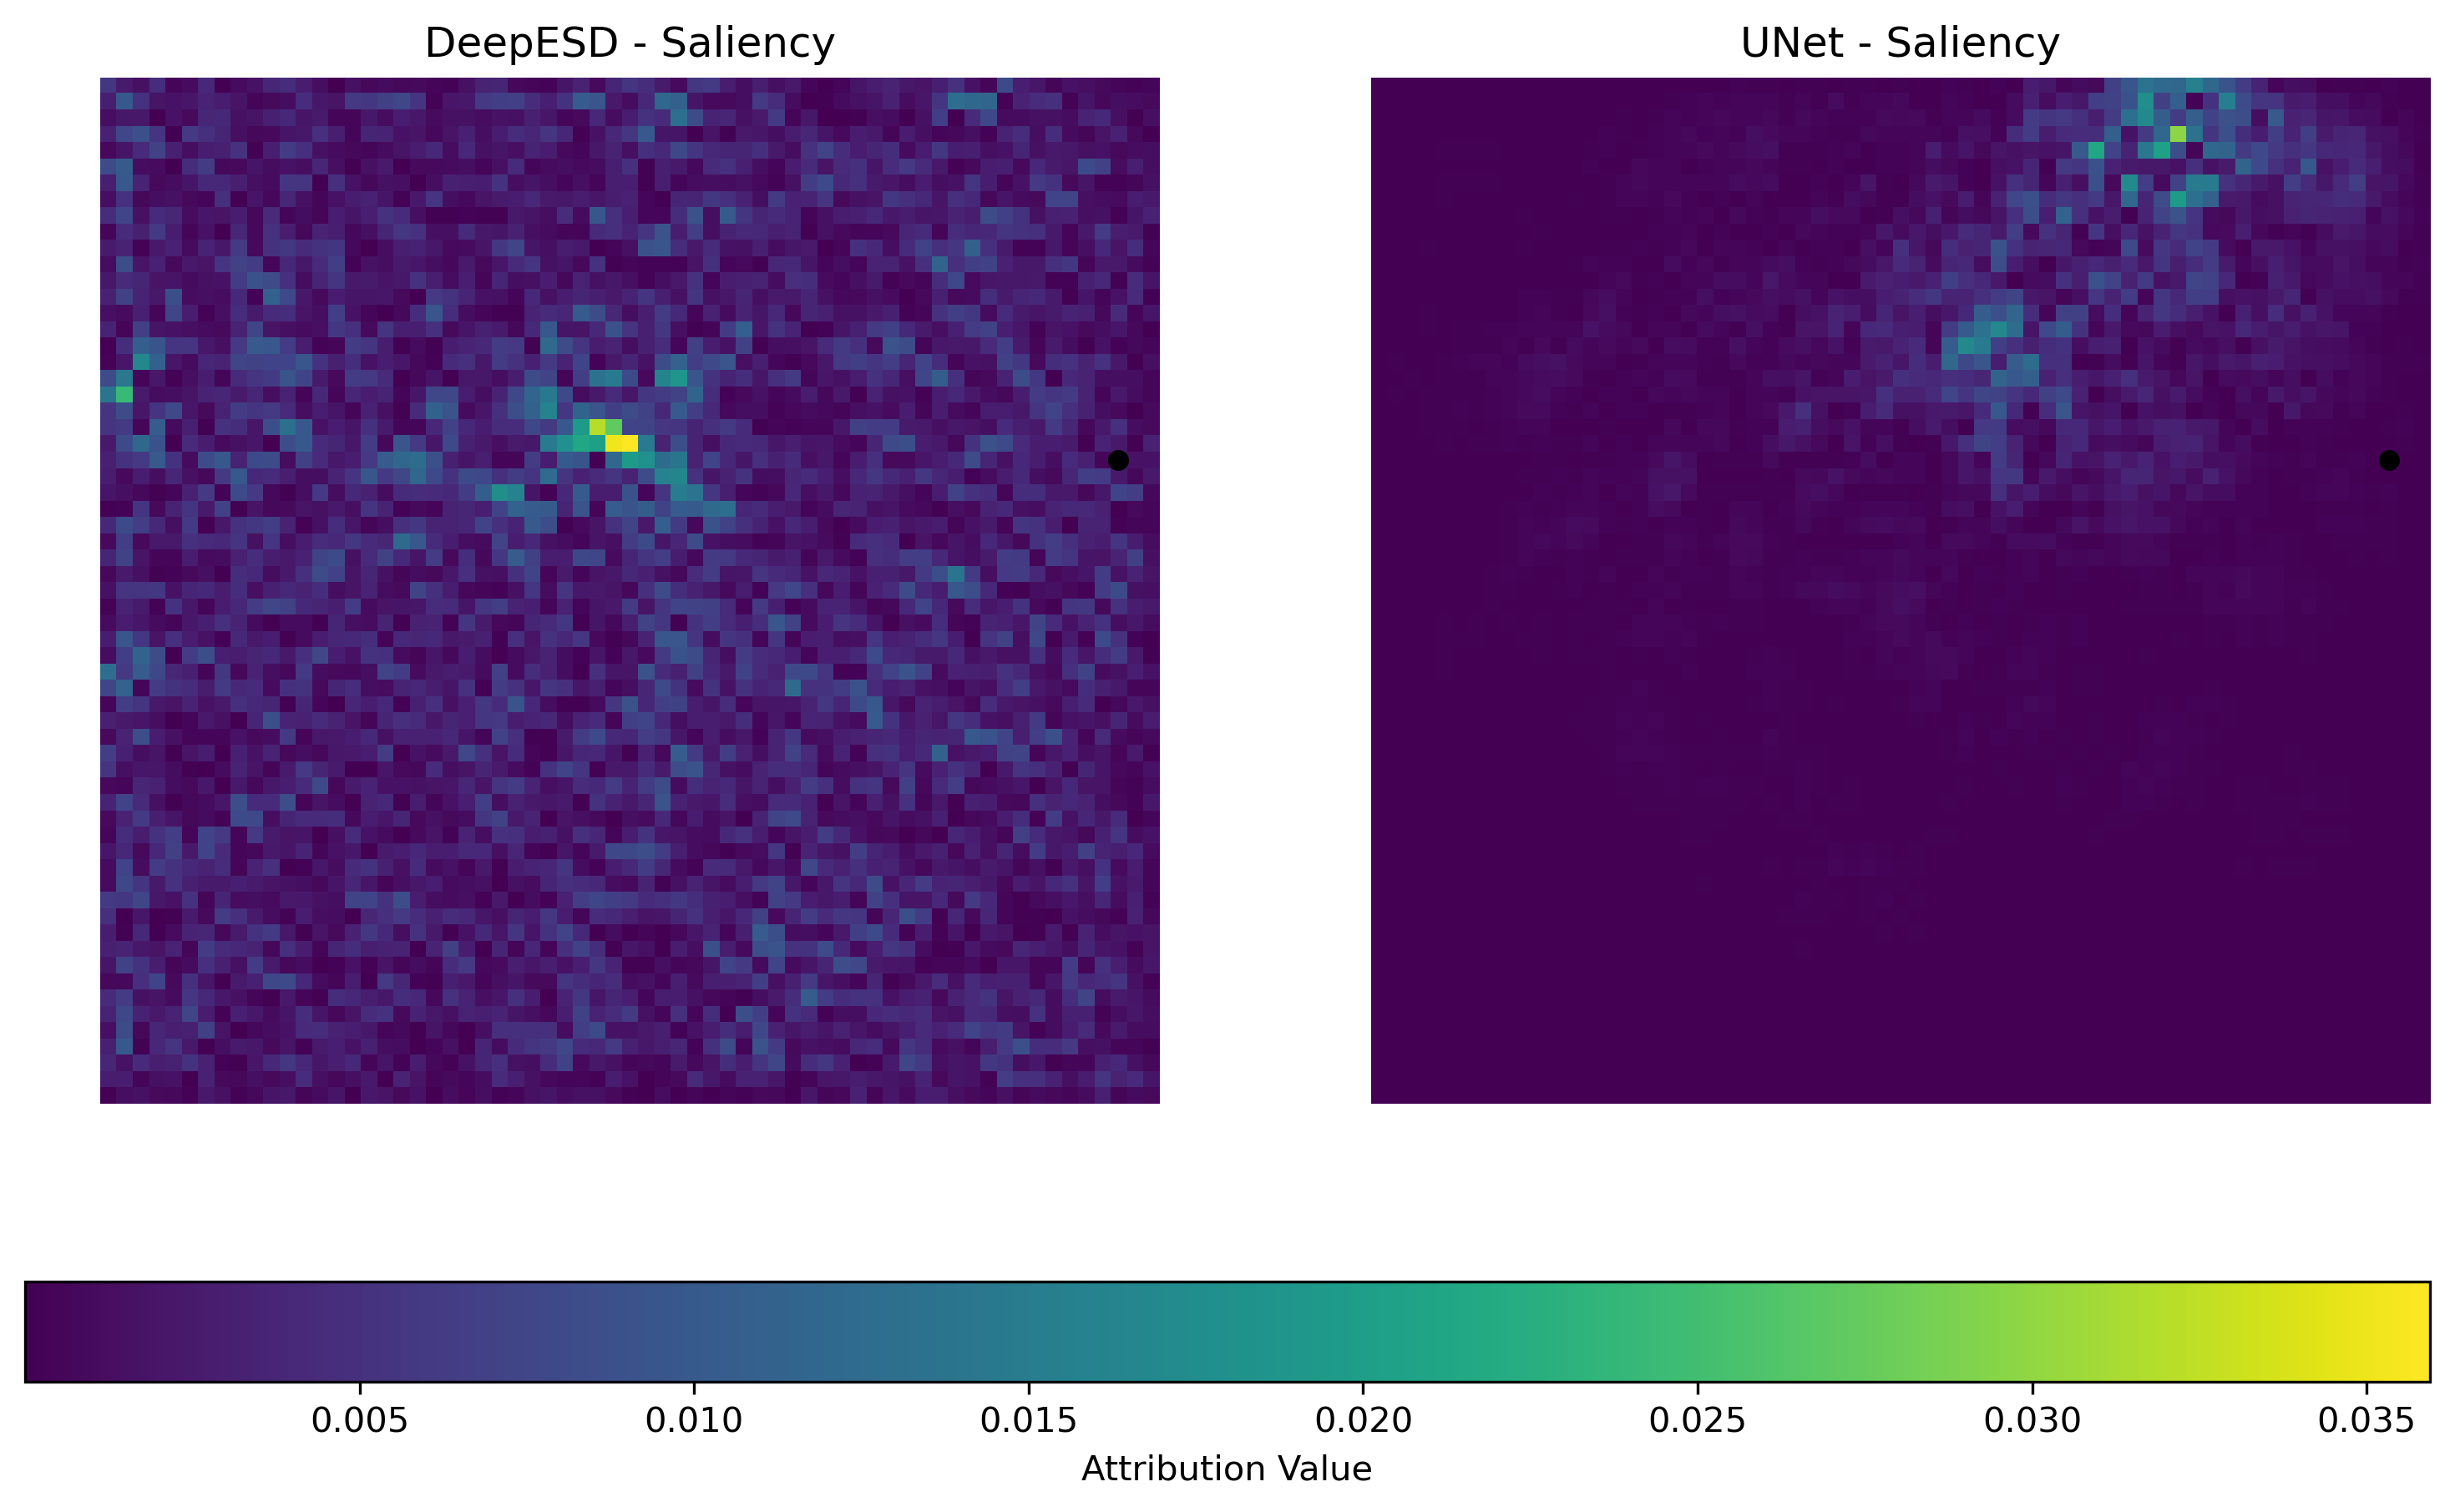

INFO:root:📸 Figure saved to ../outputs/figures/explainability/ig_pixel1.png


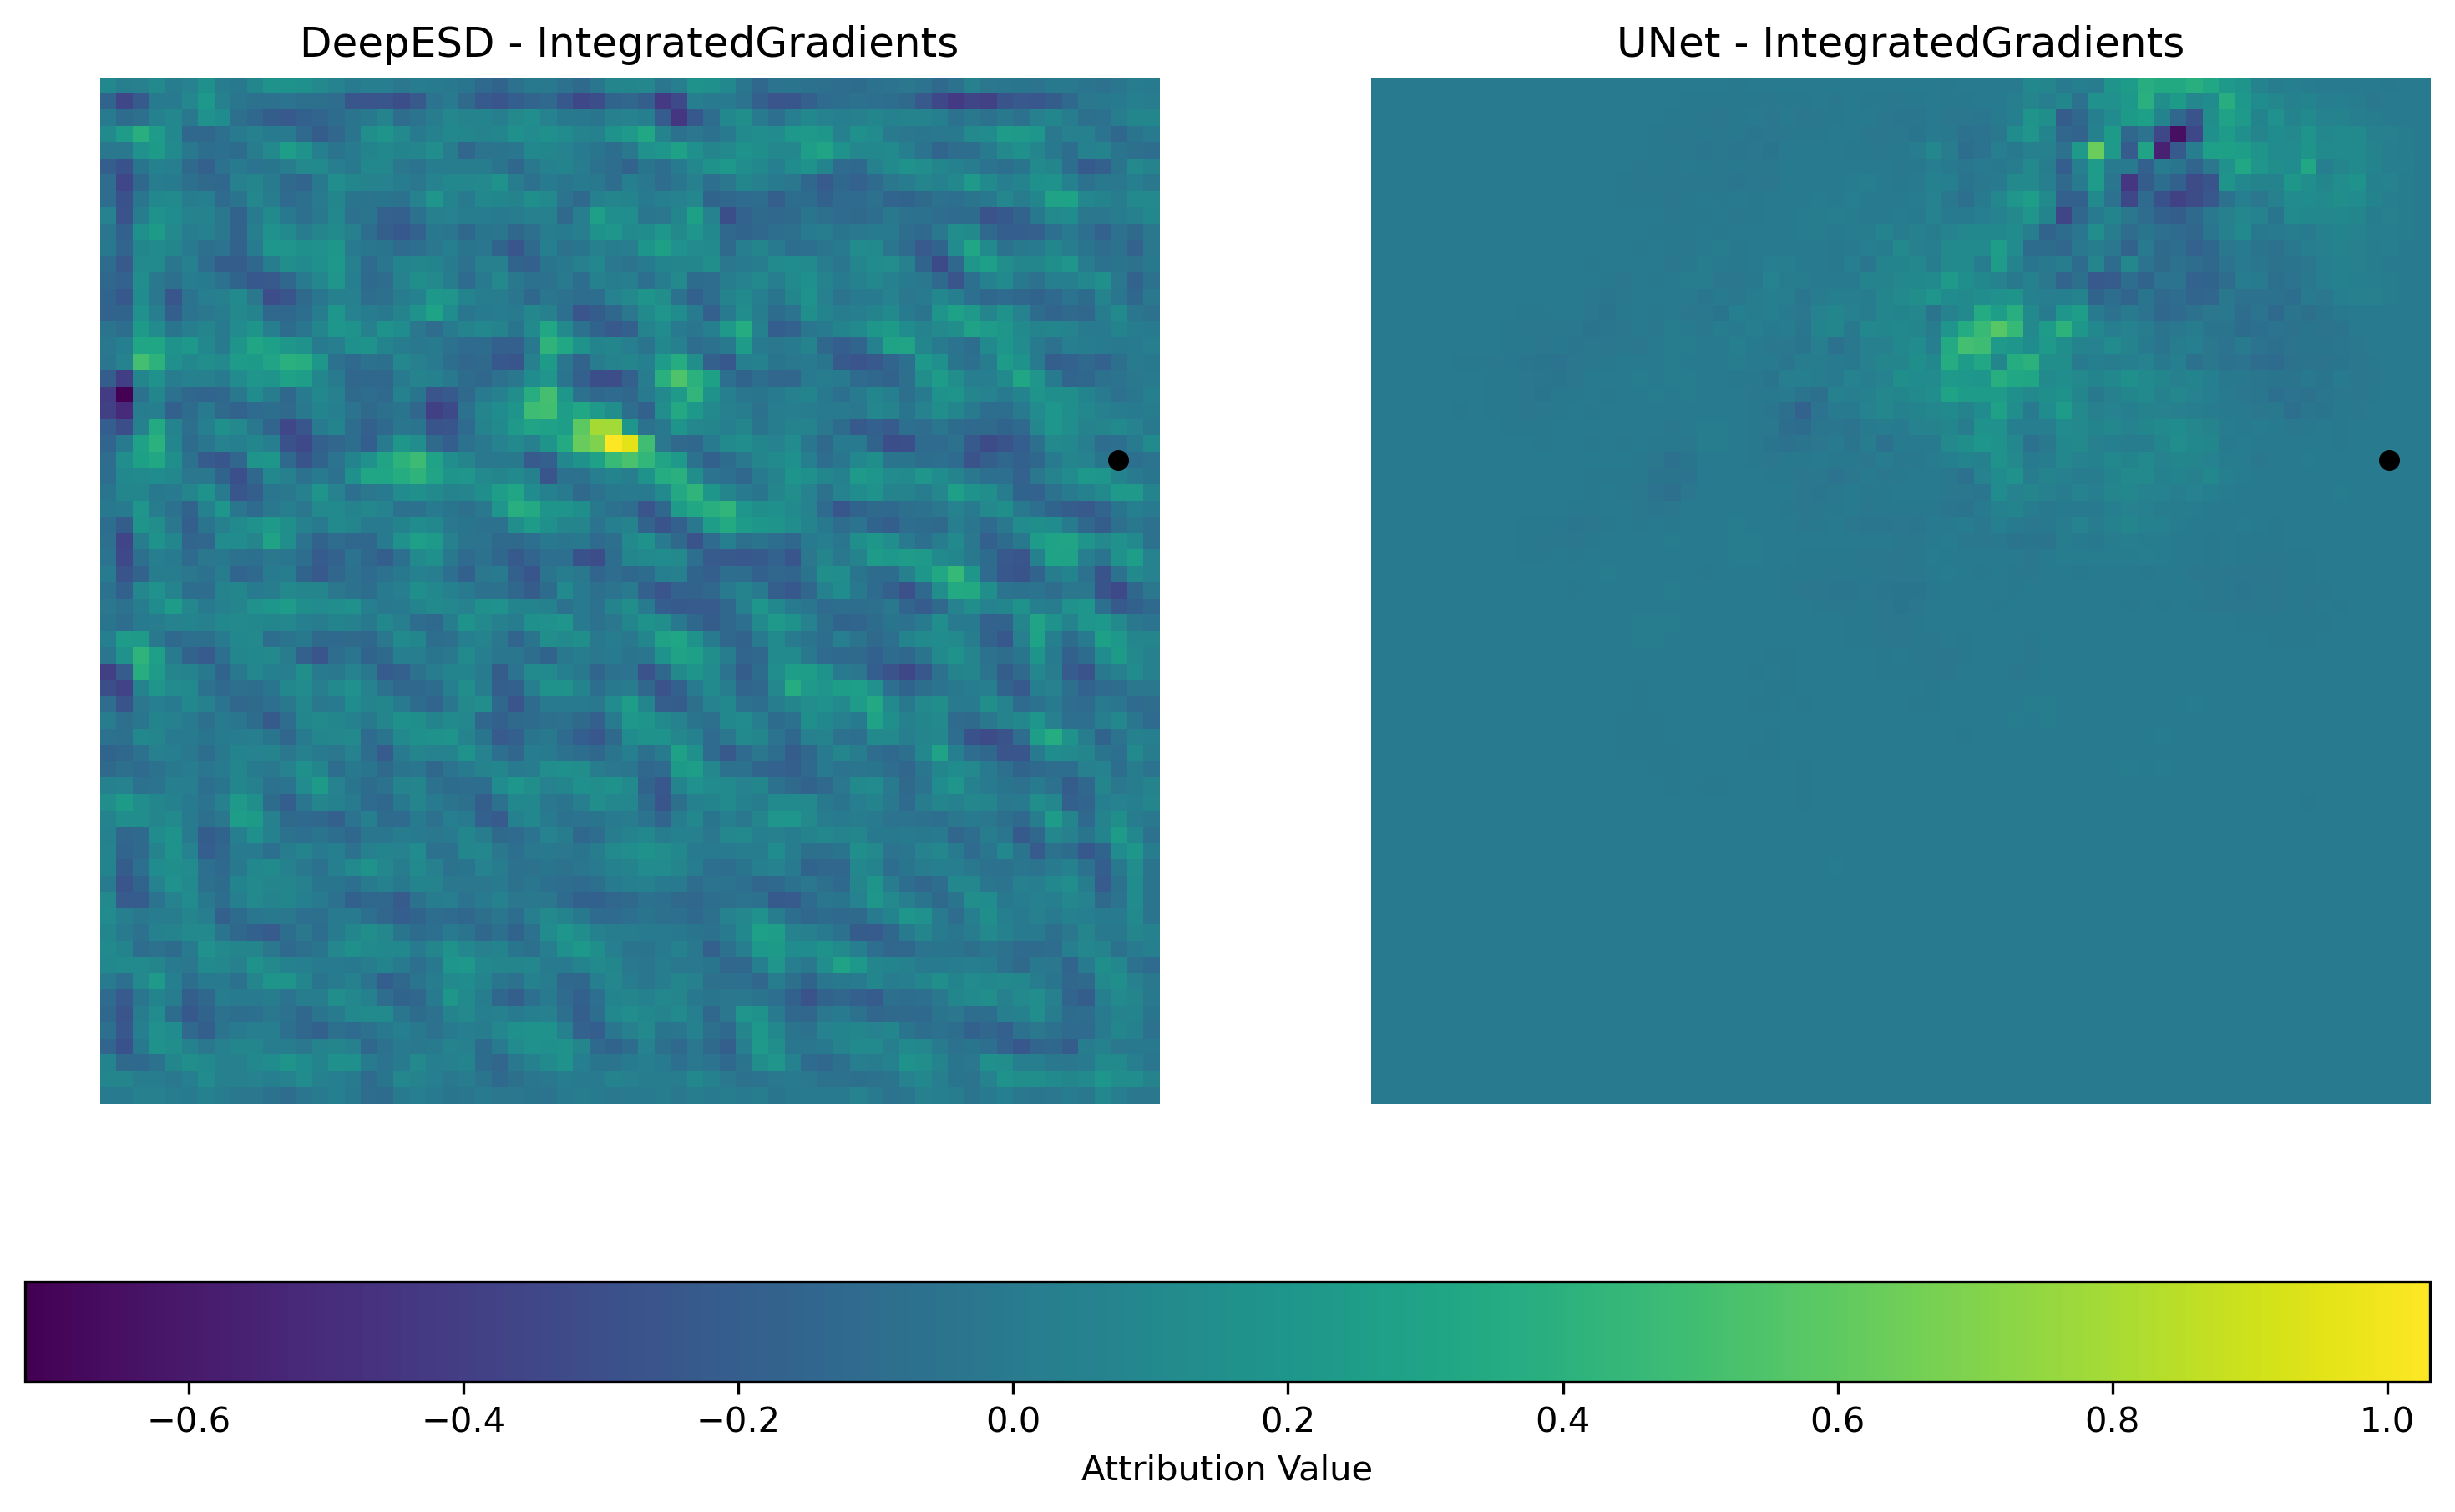

INFO:root:📸 Figure saved to ../outputs/figures/explainability/saliency_pixel2.png


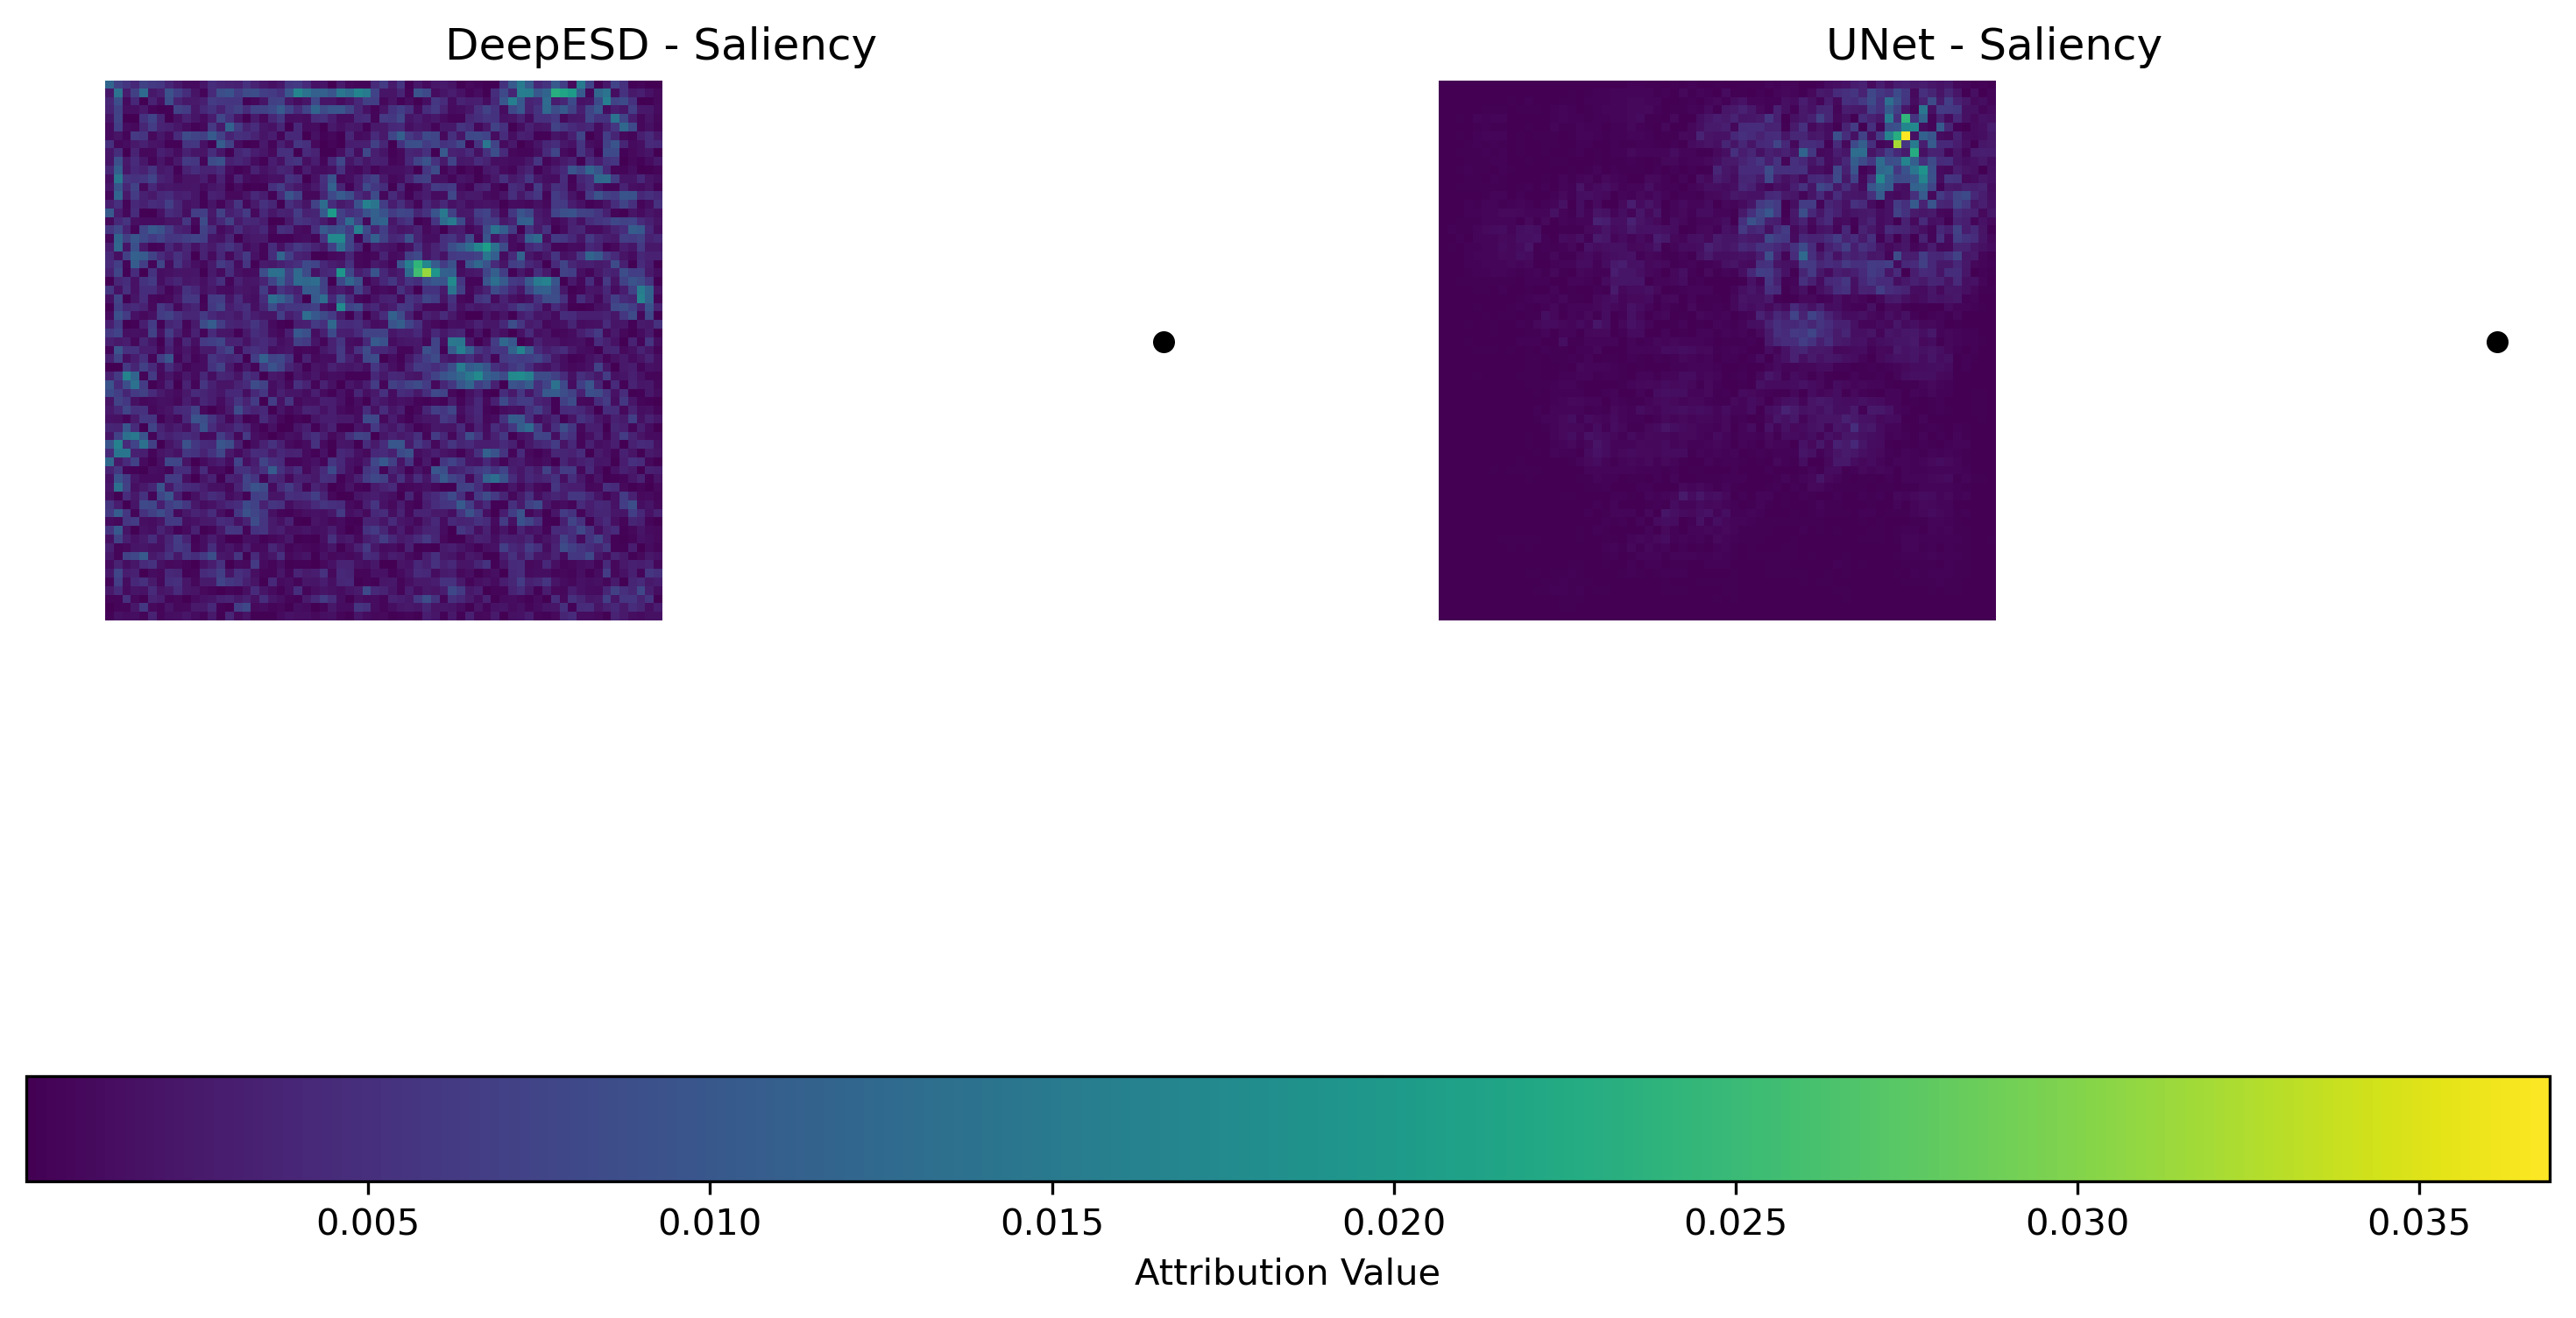

INFO:root:📸 Figure saved to ../outputs/figures/explainability/ig_pixel2.png


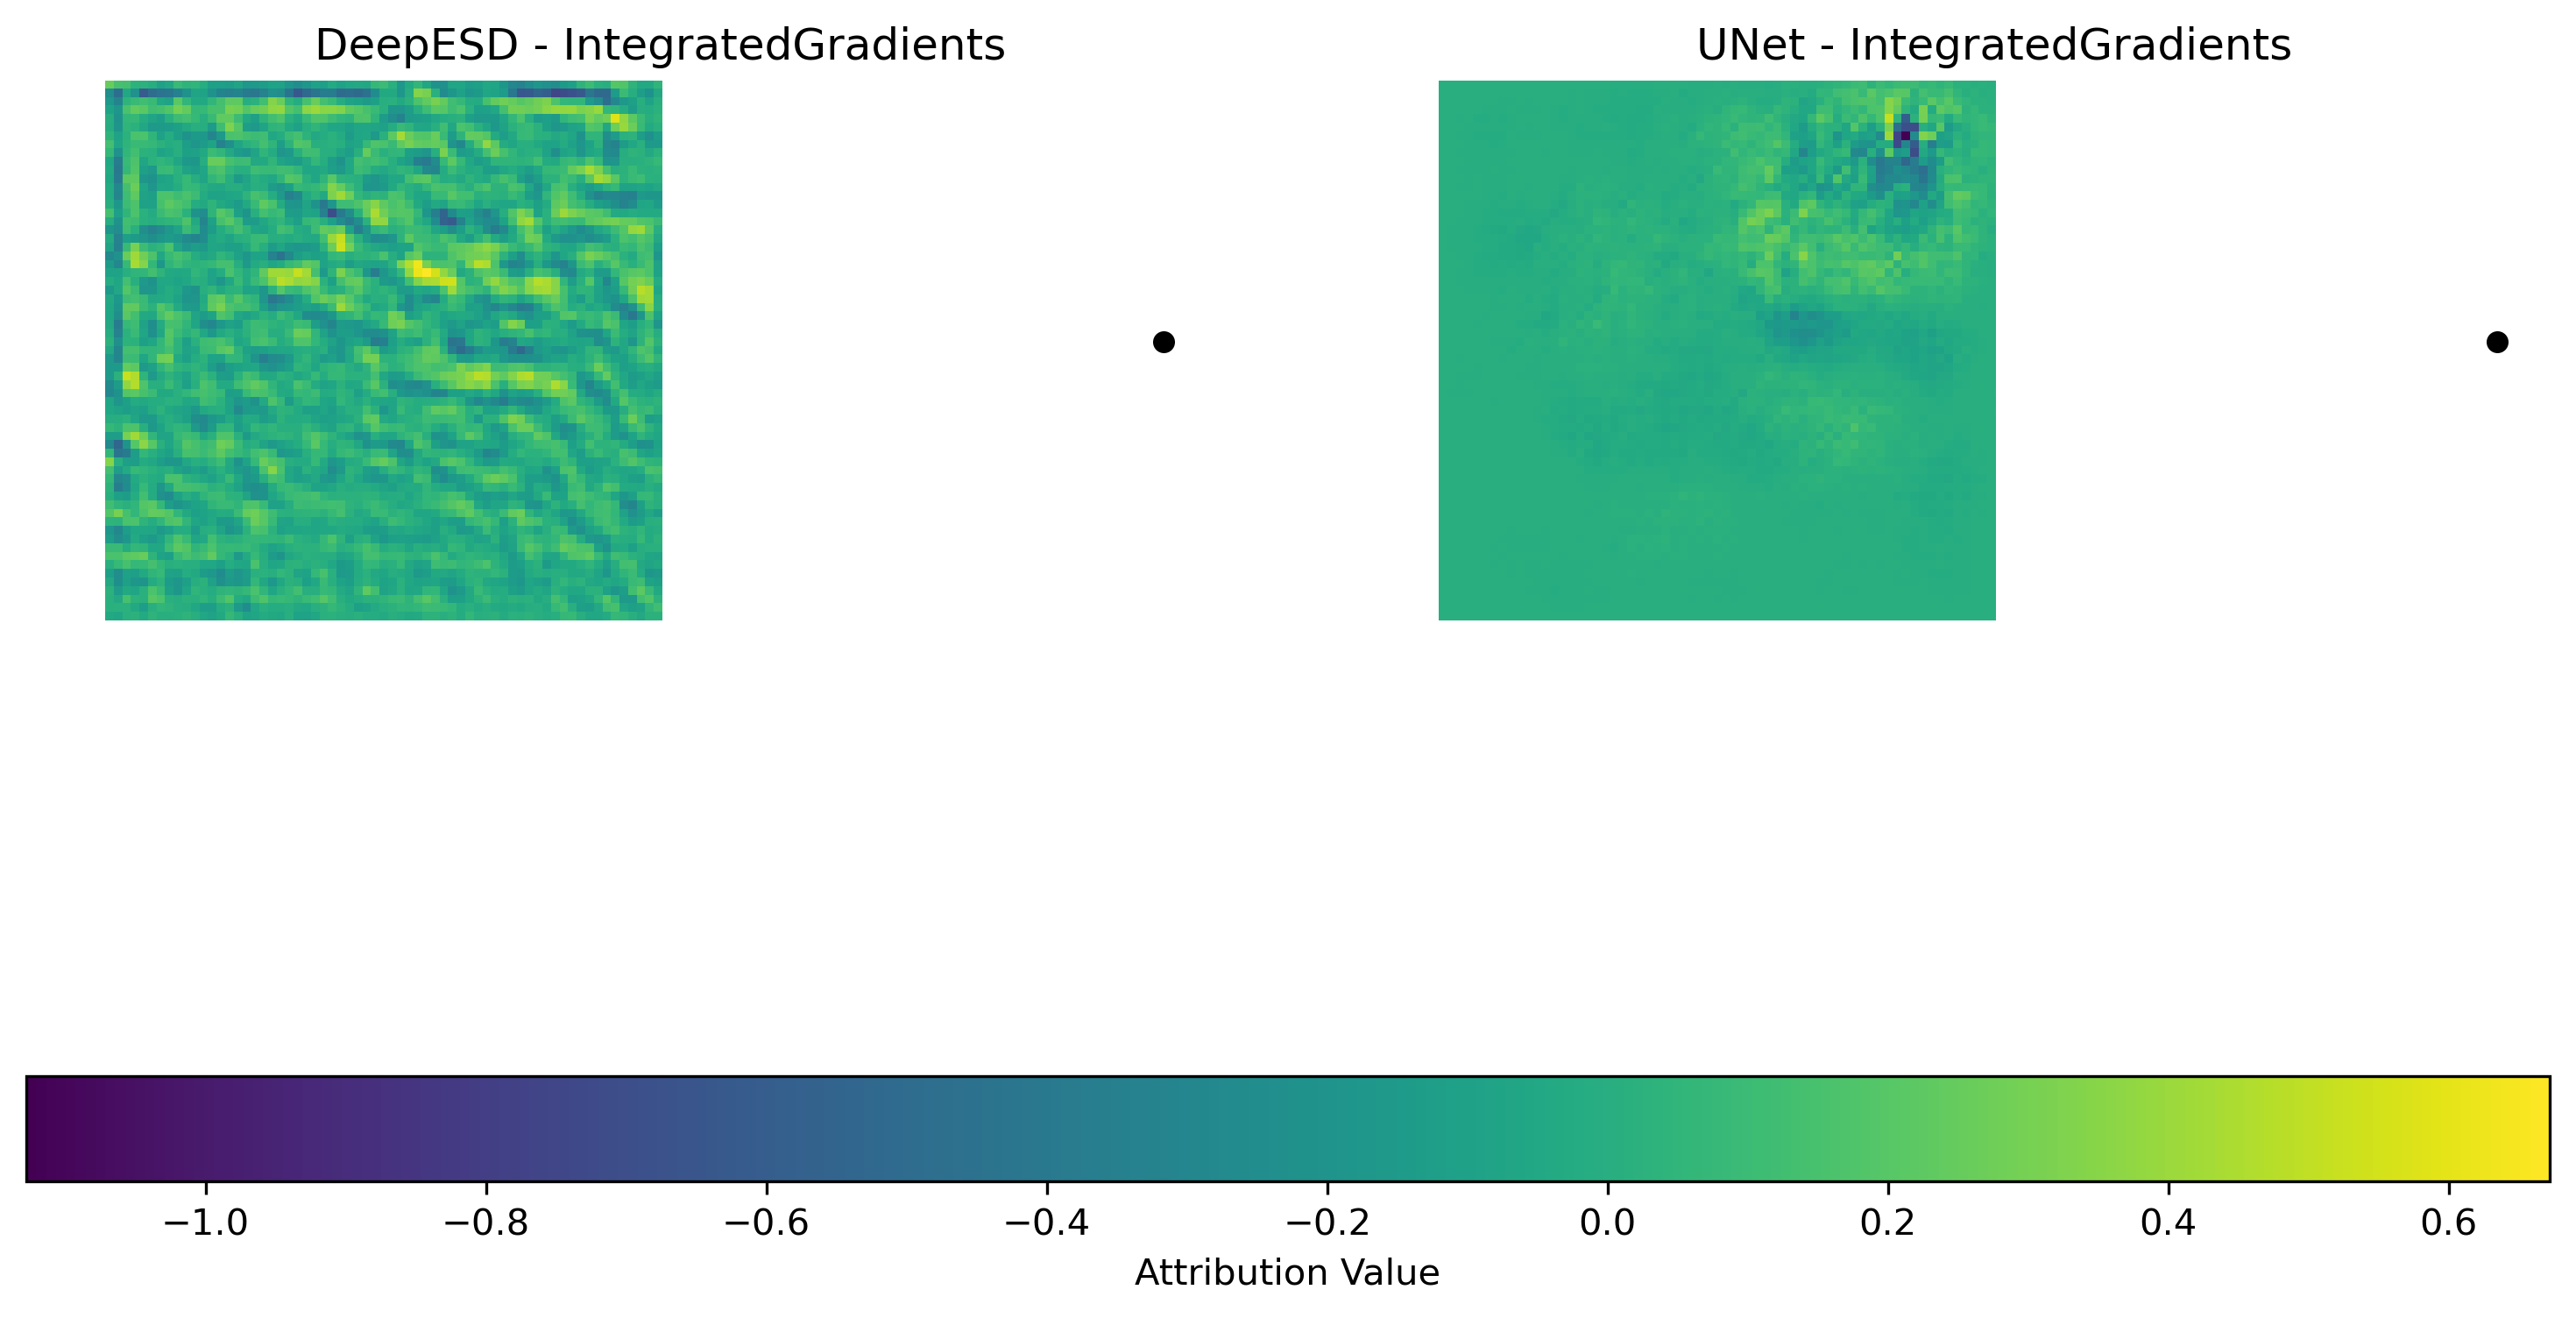

INFO:root:📸 Figure saved to ../outputs/figures/explainability/saliency_pixel3.png


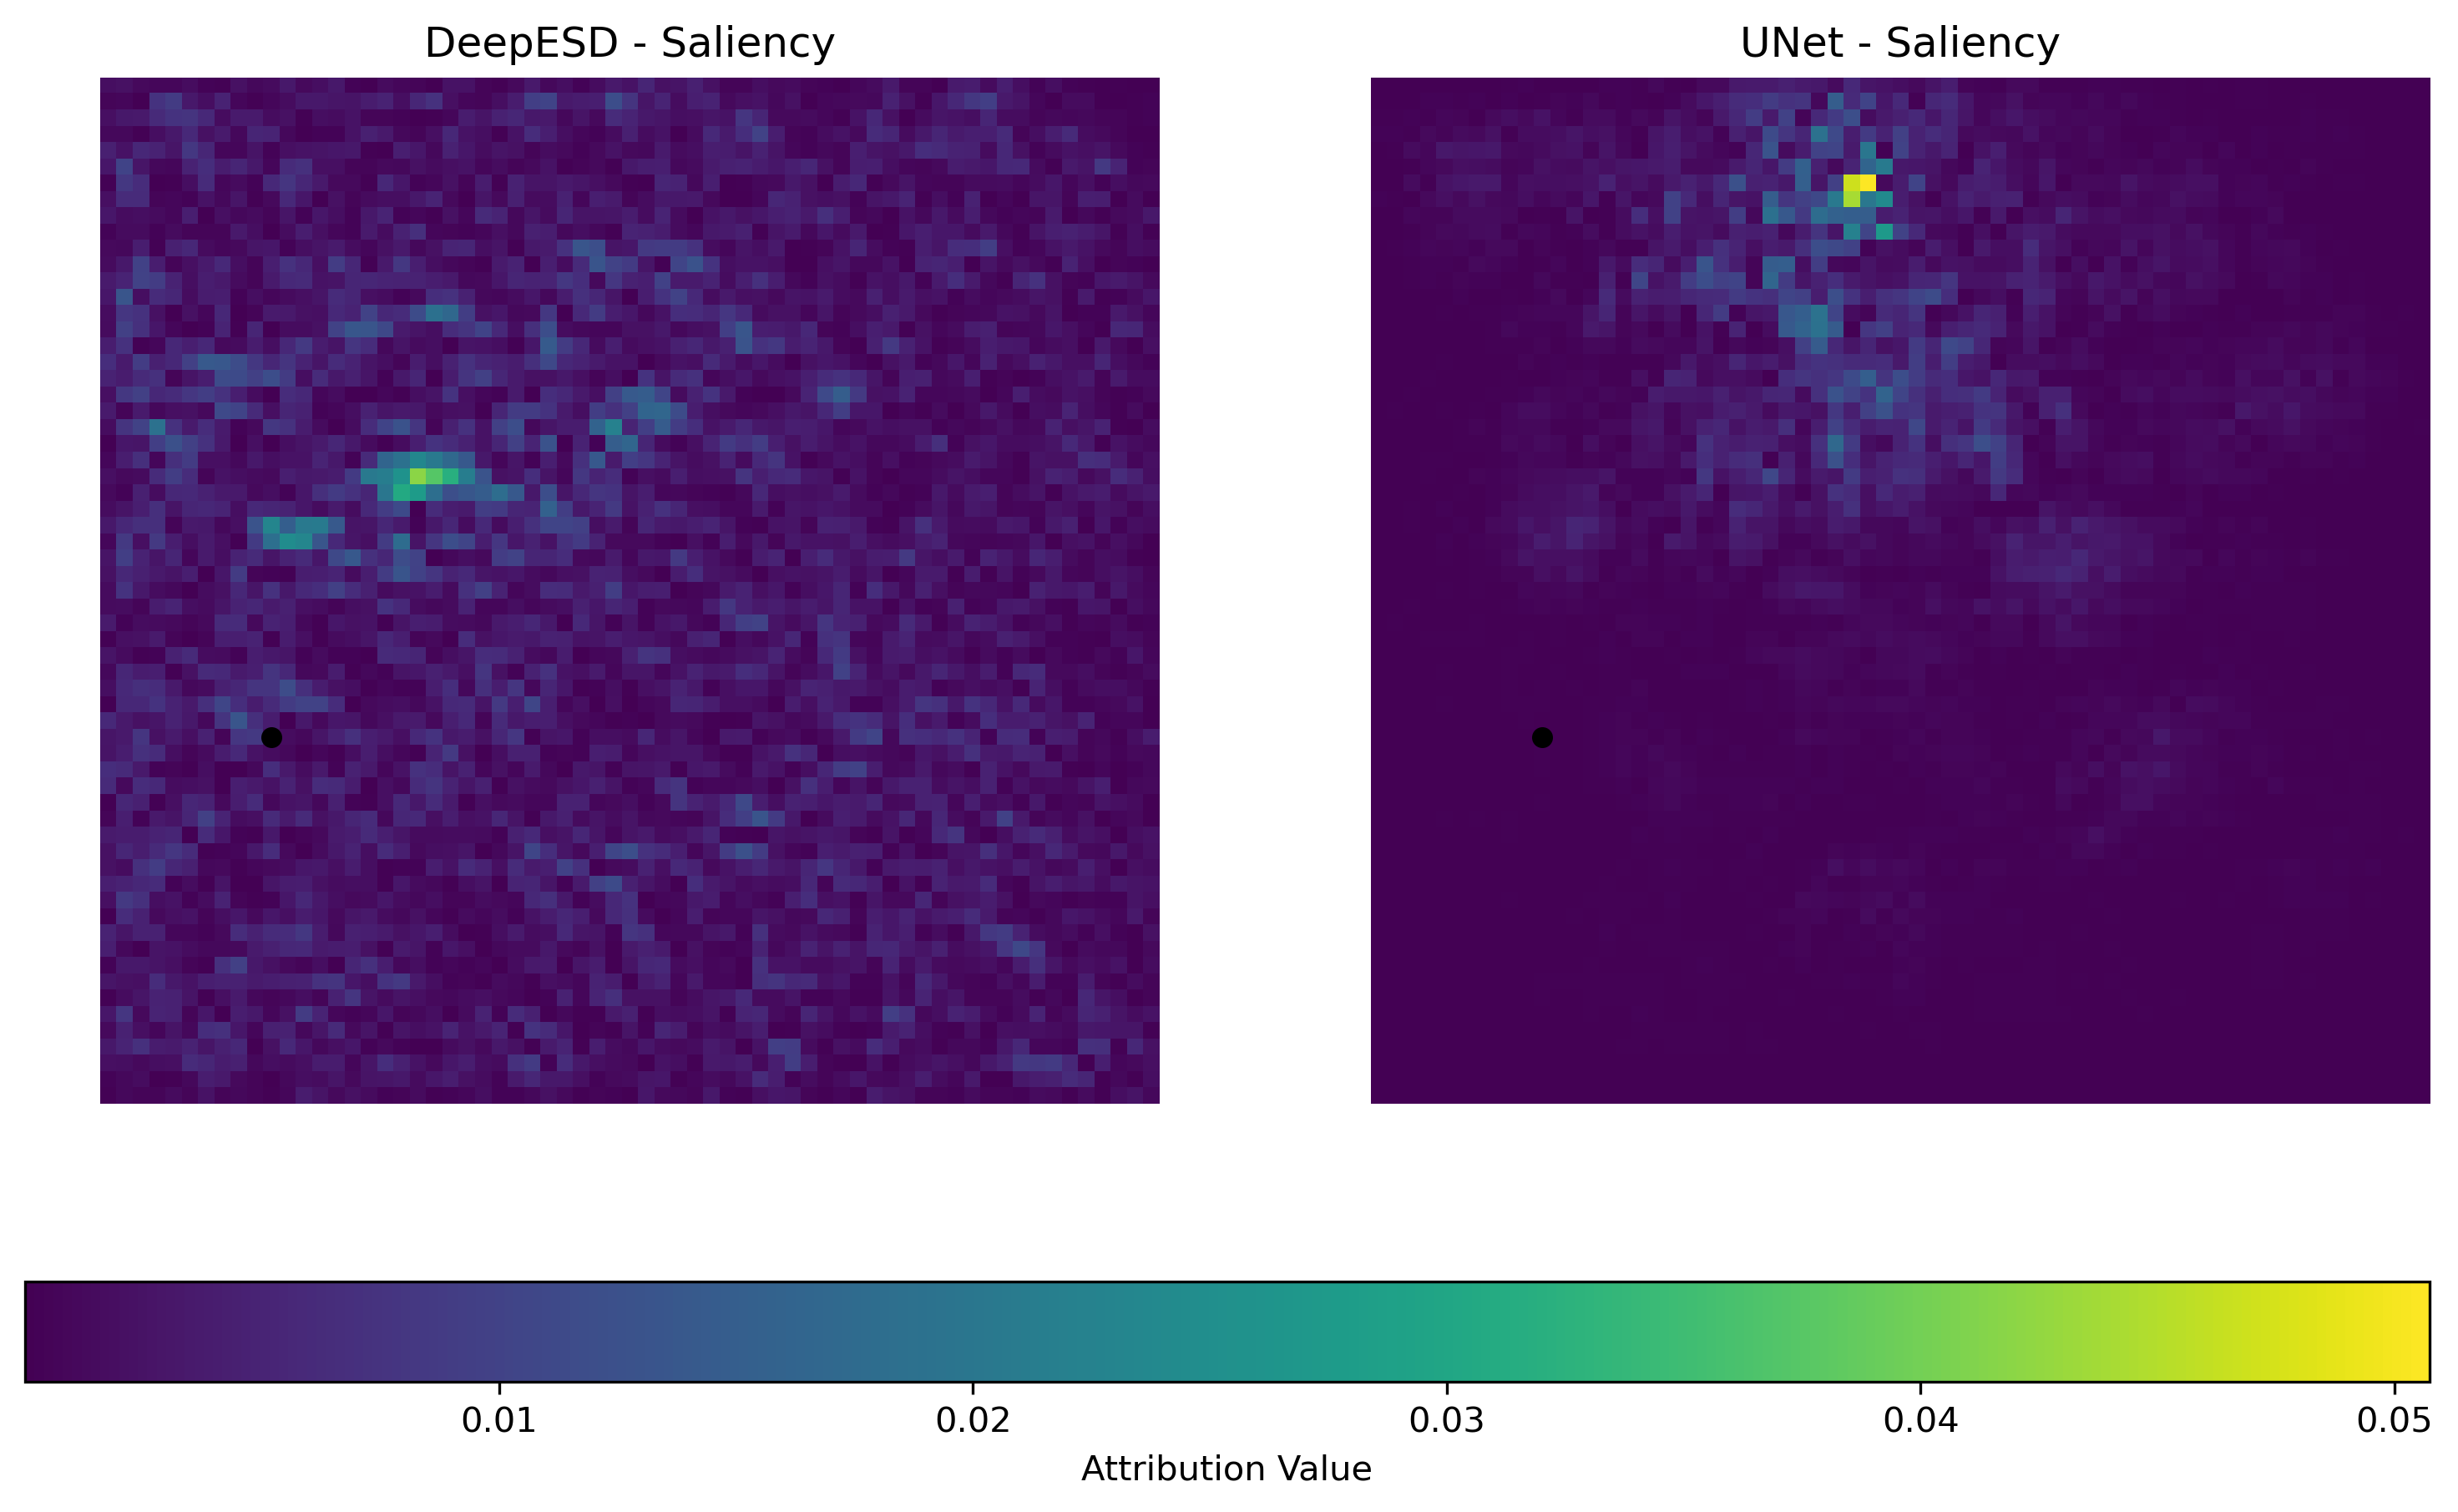

INFO:root:📸 Figure saved to ../outputs/figures/explainability/ig_pixel3.png


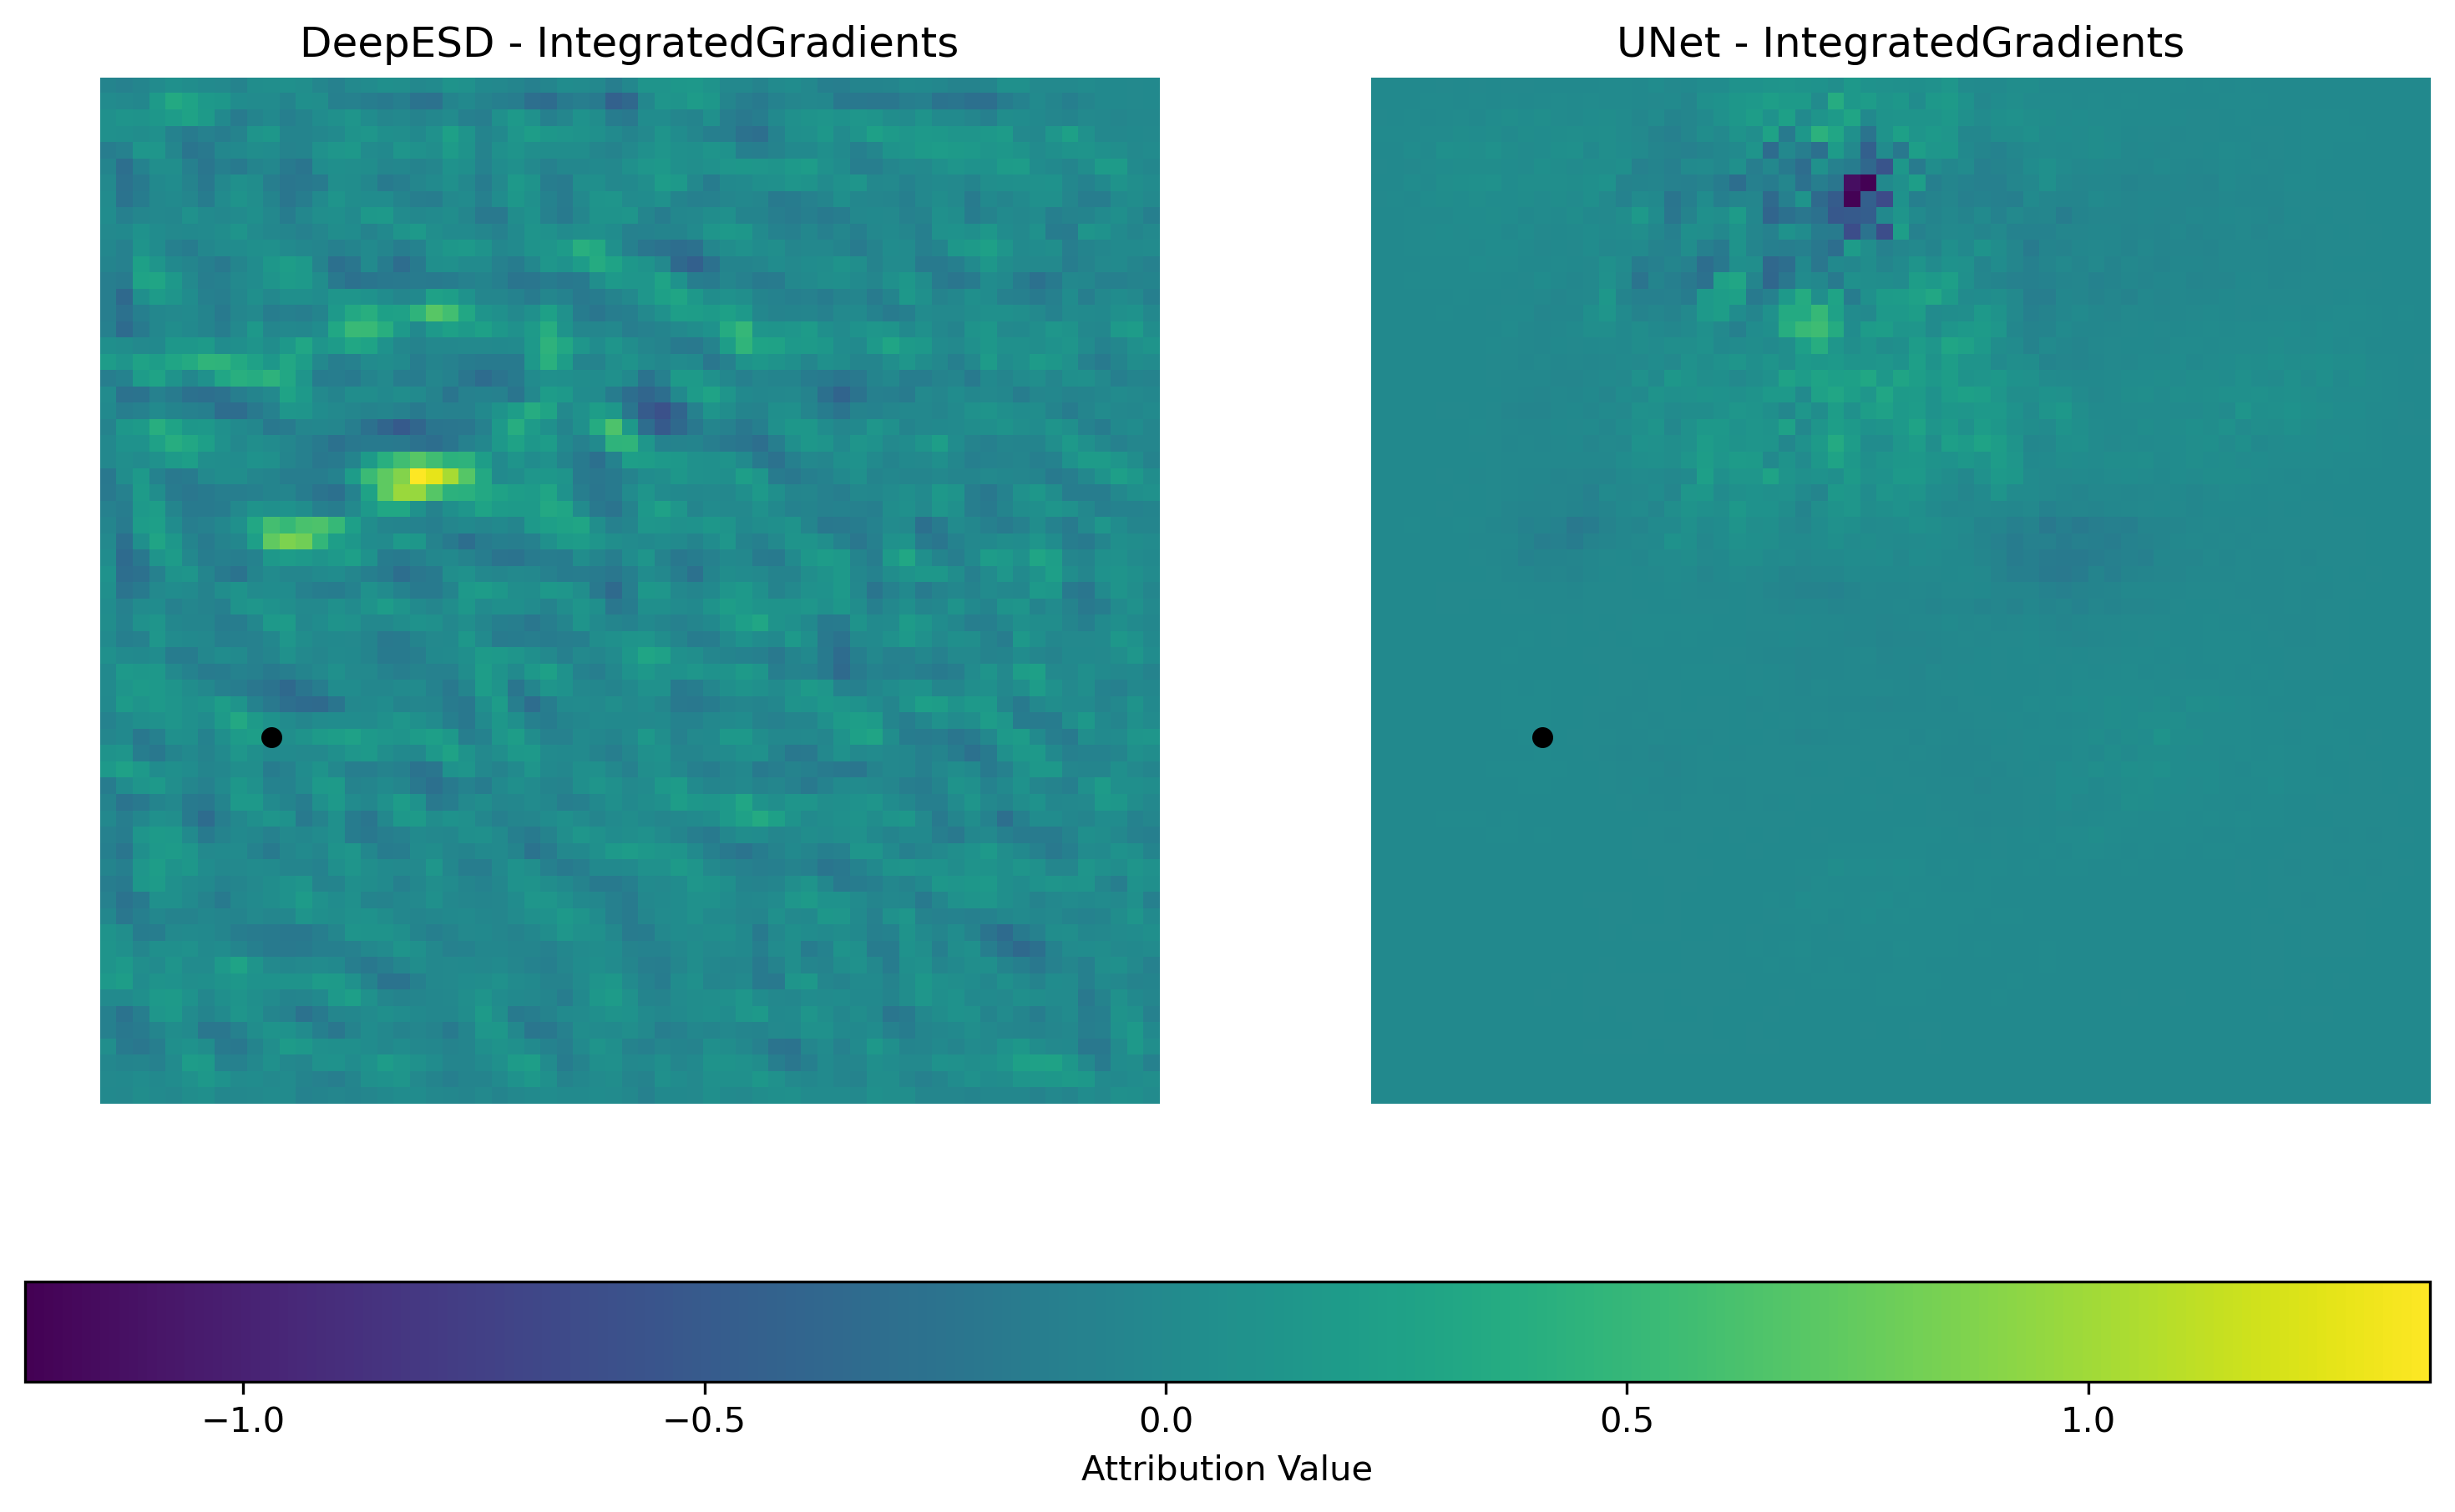

INFO:root:📸 Figure saved to ../outputs/figures/explainability/saliency_pixel4.png


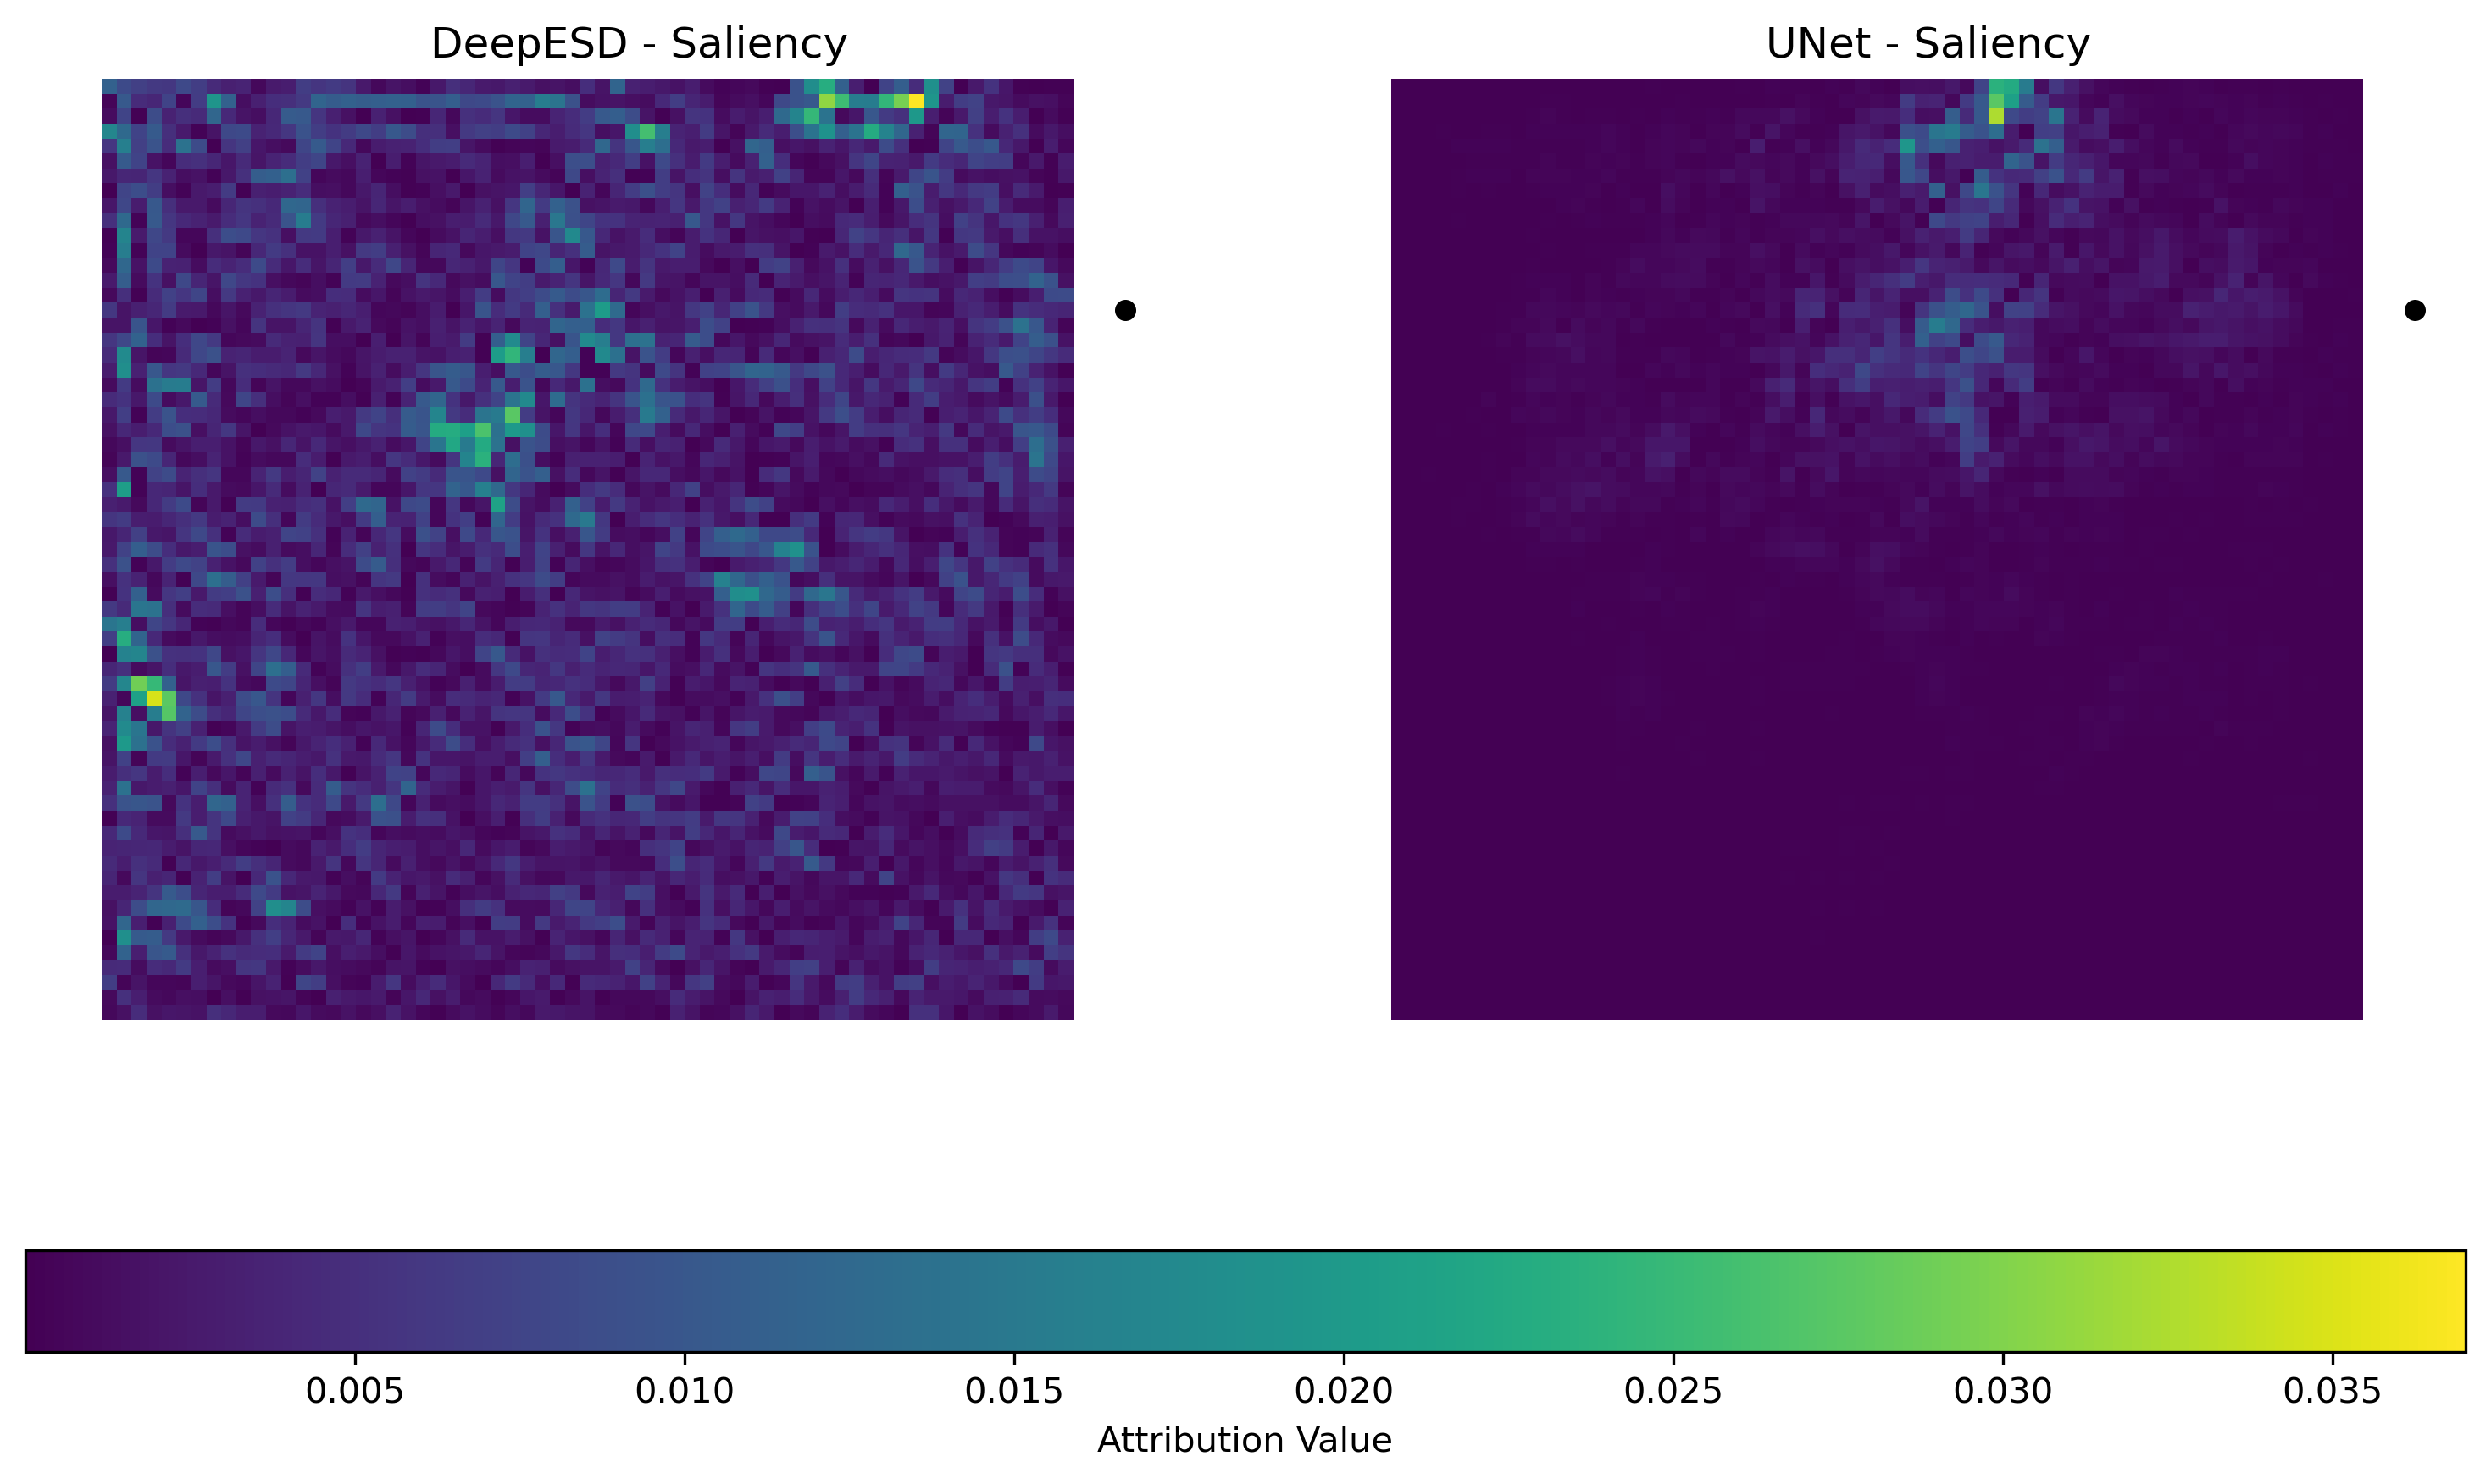

INFO:root:📸 Figure saved to ../outputs/figures/explainability/ig_pixel4.png


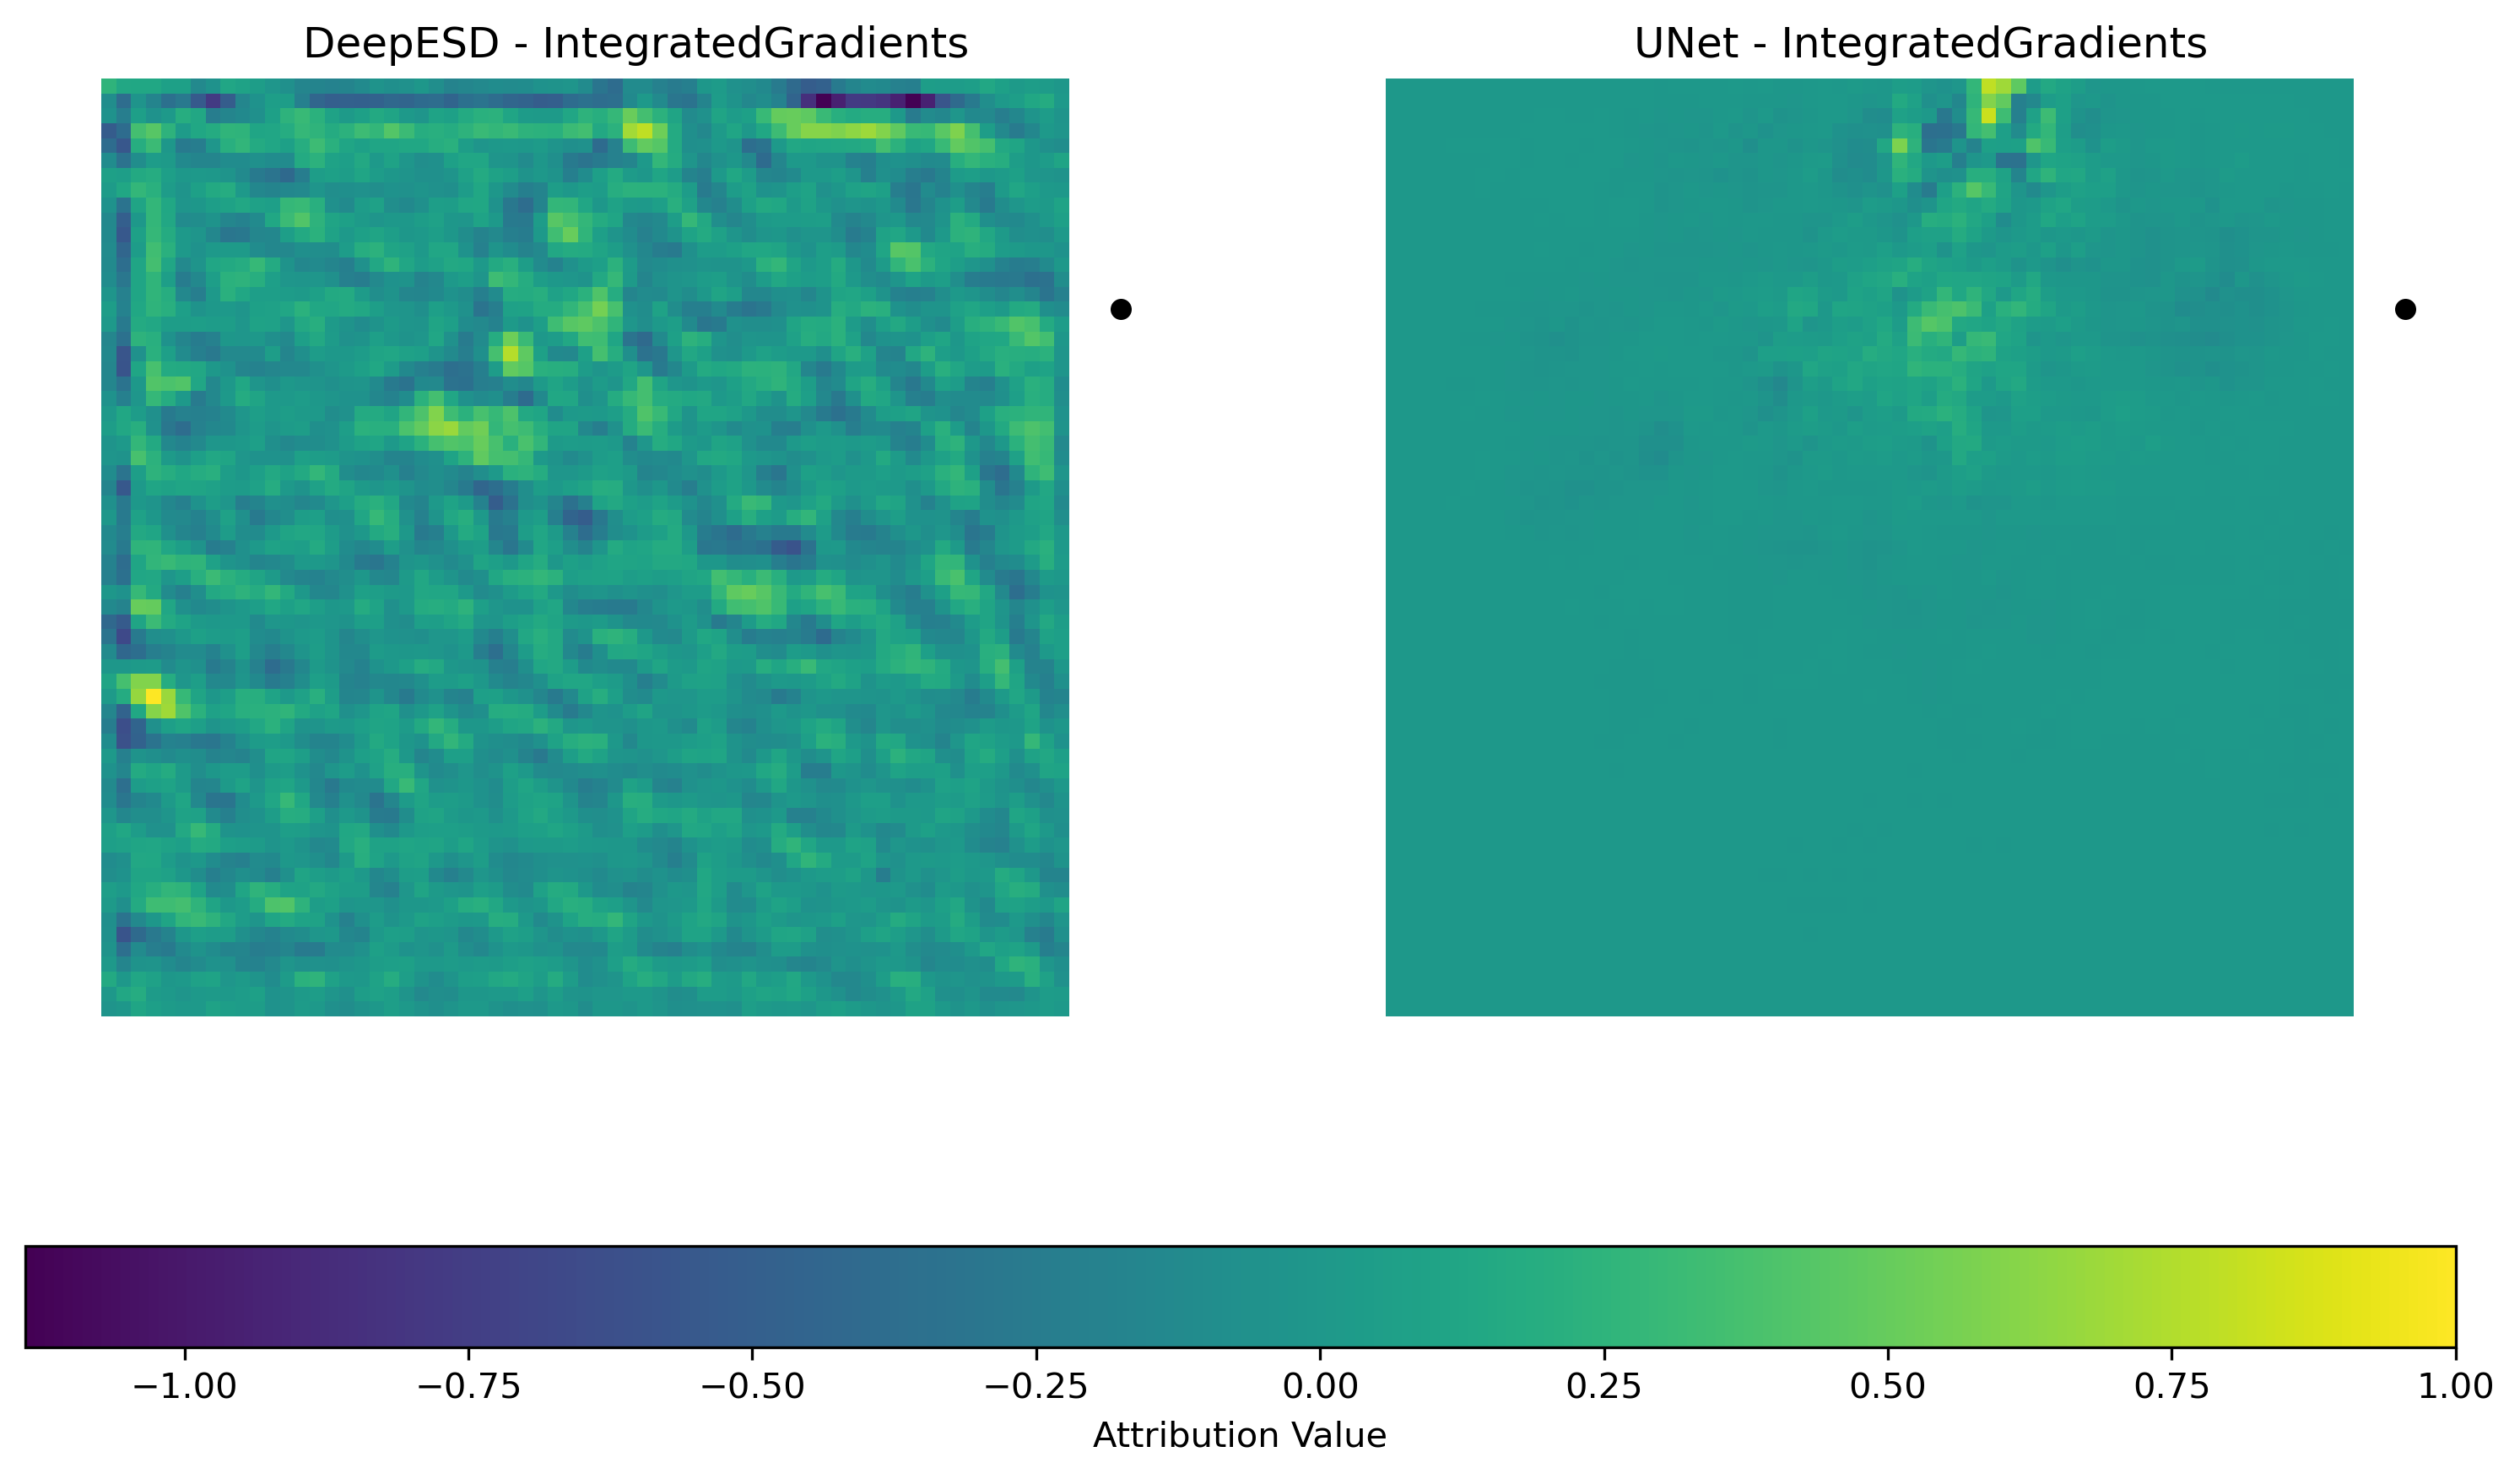

INFO:root:📸 Figure saved to ../outputs/figures/explainability/saliency_pixel5.png


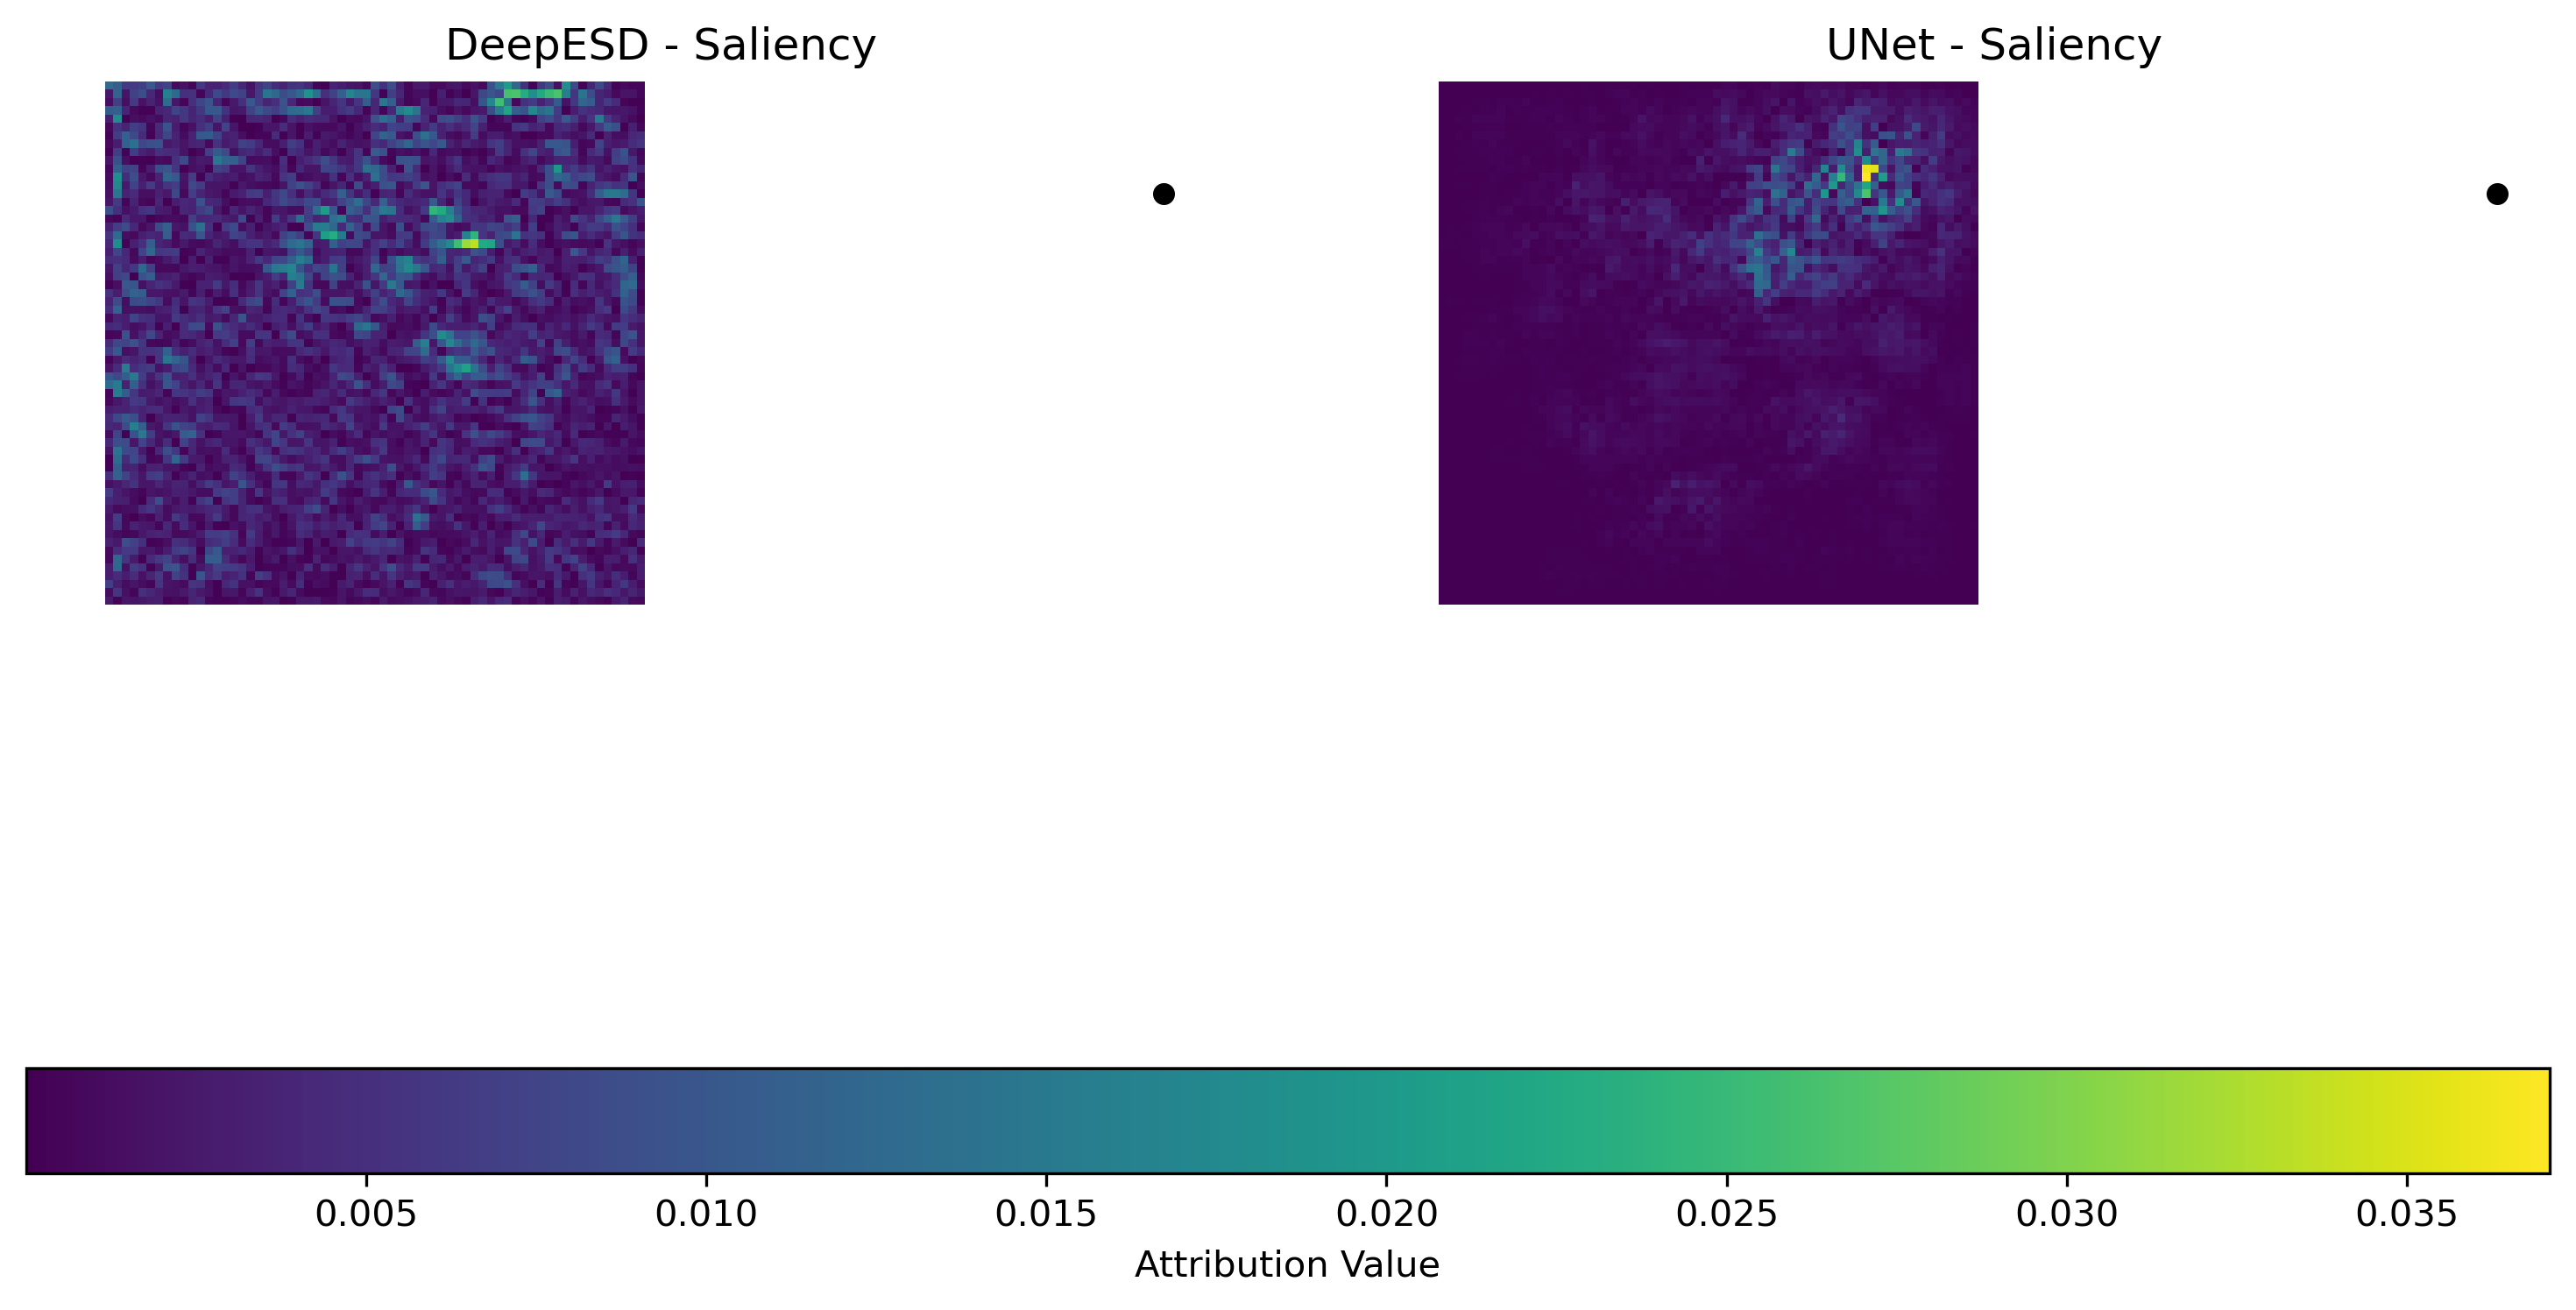

INFO:root:📸 Figure saved to ../outputs/figures/explainability/ig_pixel5.png


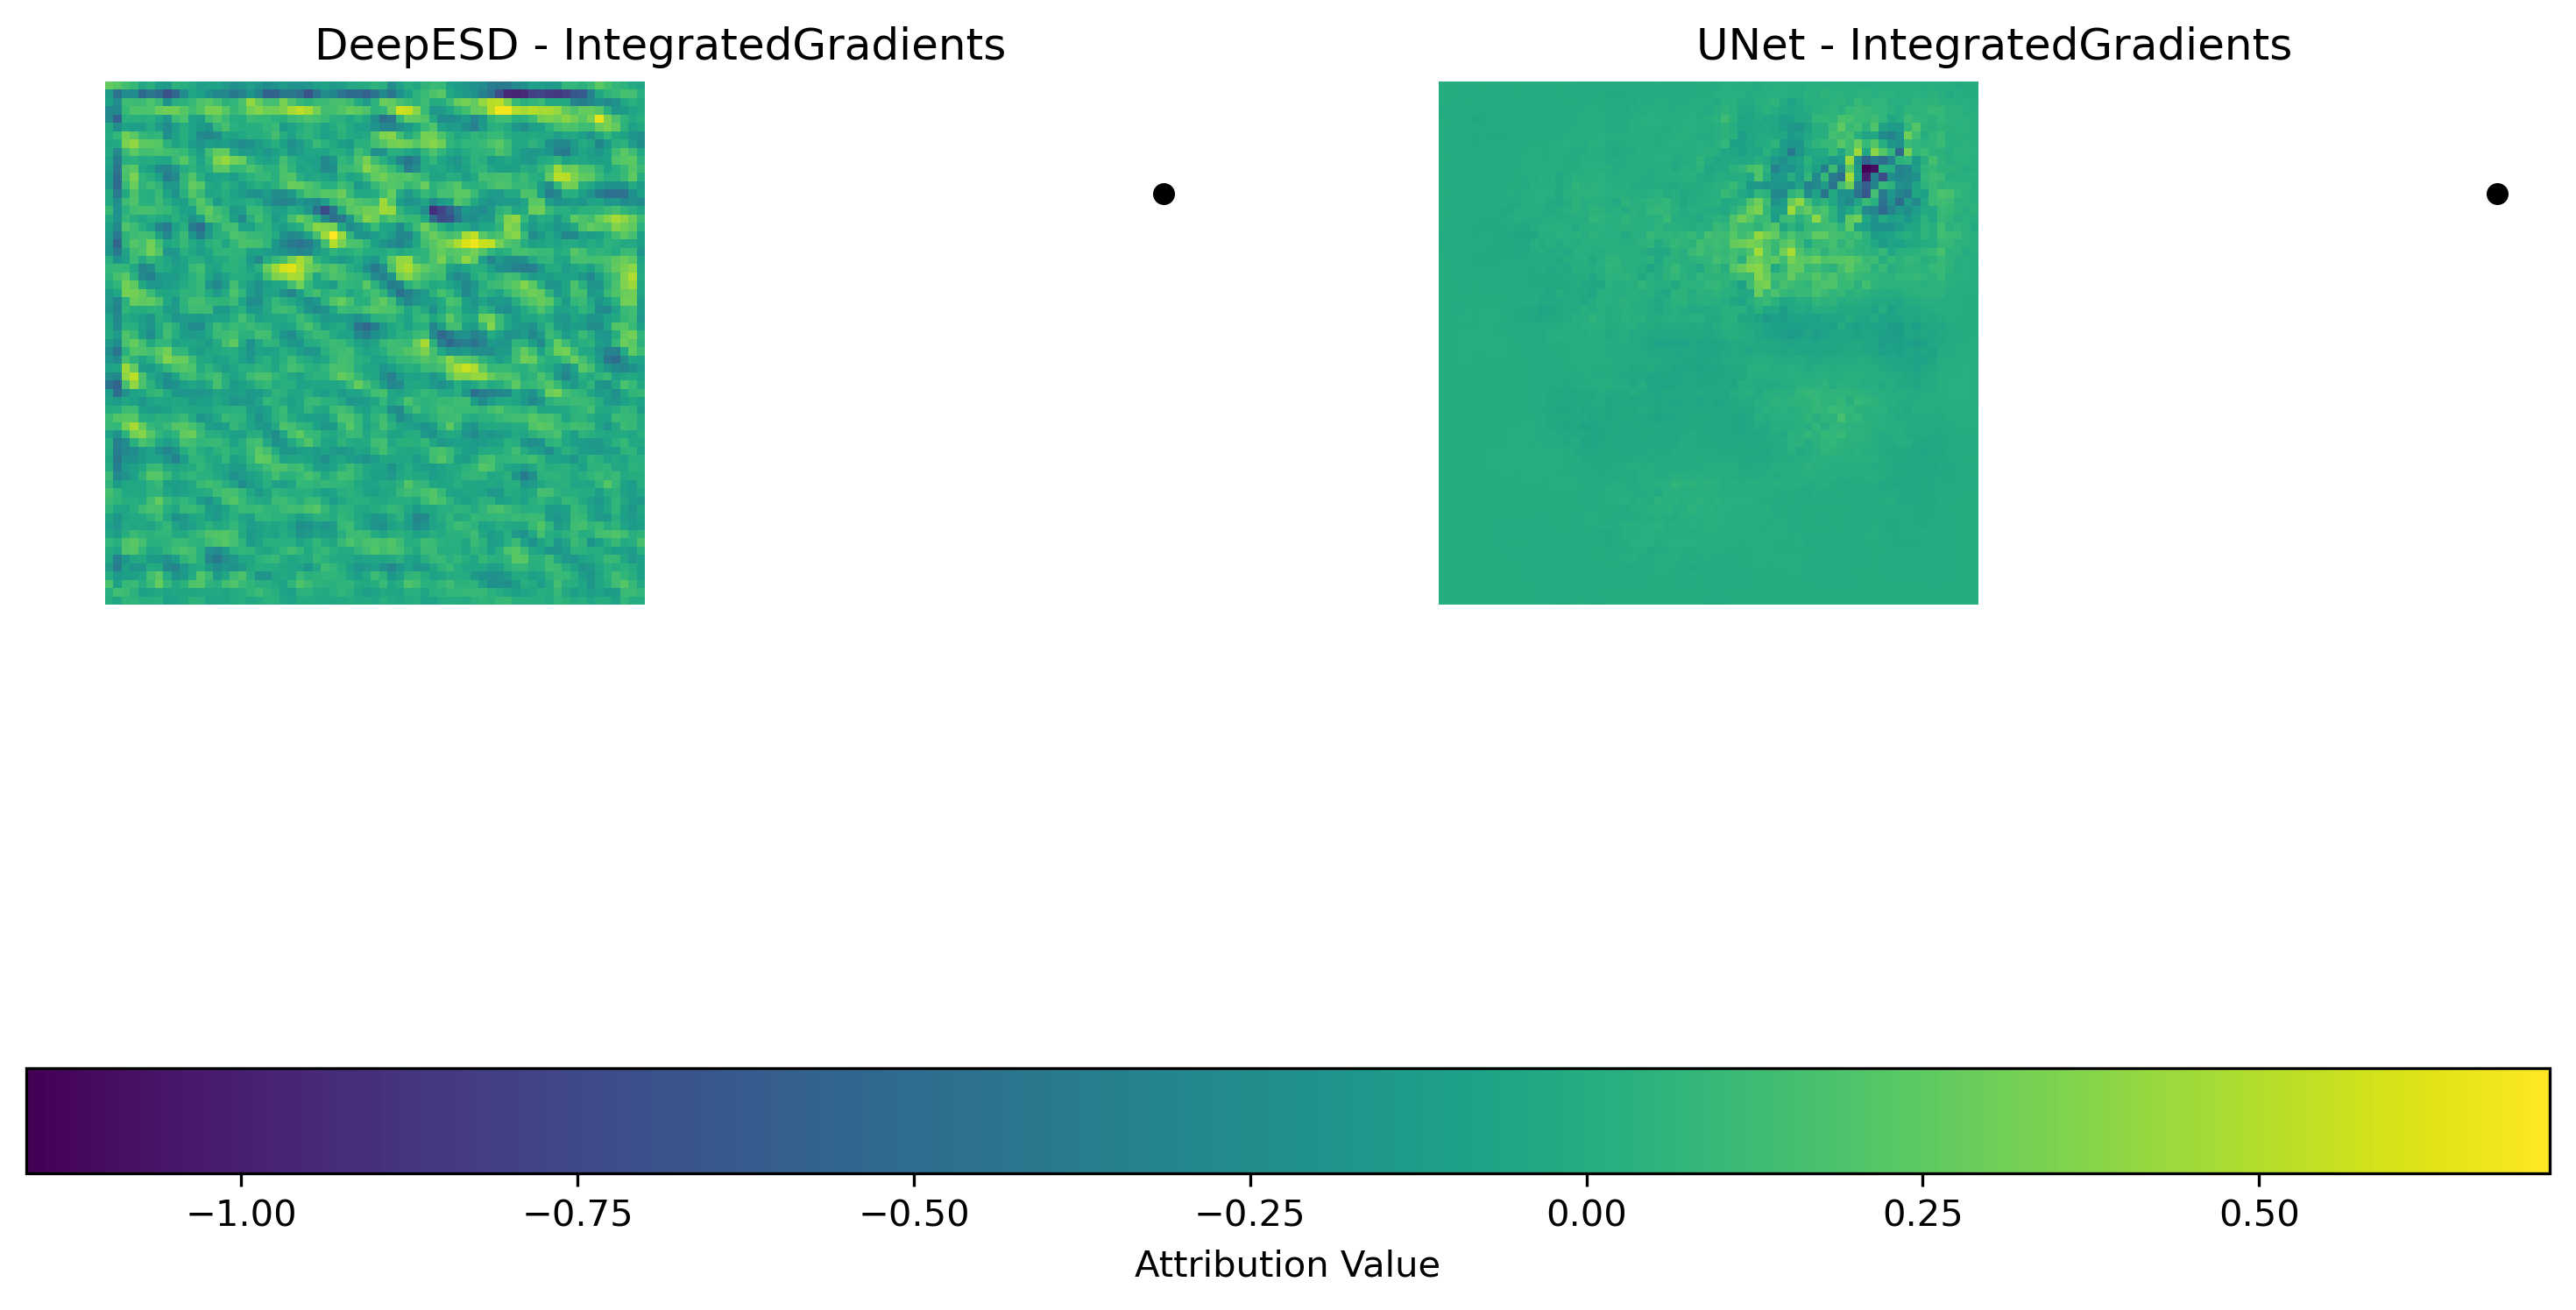

In [9]:
# Generate and save explanation figures
for i in range(5):
    lat_idx, lon_idx = deepesd_pixels[i]

    output_path = plot_explanation_map(
        attributions["DeepESD"]["saliency"][i],
        attributions["UNet"]["saliency"][i],
        titles=["DeepESD - Saliency", "UNet - Saliency"],
        suptitle=f"Pixel {i+1} - Saliency",
        filename=f"../outputs/figures/explainability/saliency_pixel{i+1}.png",
        pixel_coords=(lat_idx, lon_idx),
    )
    logging.info(f"📸 Figure saved to {output_path}")
    display(Image(output_path))

    output_path = plot_explanation_map(
        attributions["DeepESD"]["ig"][i],
        attributions["UNet"]["ig"][i],
        titles=["DeepESD - IntegratedGradients", "UNet - IntegratedGradients"],
        suptitle=f"Pixel {i+1} - Integrated Gradients",
        filename=f"../outputs/figures/explainability/ig_pixel{i+1}.png",
        pixel_coords=(lat_idx, lon_idx),
    )
    logging.info(f"📸 Figure saved to {output_path}")
    display(Image(output_path))